In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network trained on selected features to descirbe degree of loss for HCMC

The chance of loss is predicted by classifier. The target_degree variable to predict by the BN are the the degree of relative content loss [fraction of content loss and total content value ] for microbusinesses . \
The transferability of the classifer and the BN is tested on the Can Tho dataset

Abbreviations in variables for chance and degre of loss
c = "chance of loss"
d = "degree of loss"
cd = contains "change and degree of loss"

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
# import logging
import numpy as np
import pandas as pd
from joblib import load
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import figures as f
import evaluation_utils as eu
import preprocessing as pp
import settings as s


seed = s.seed
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

## observed losses
# targets = [("degree of rbred", "degree of rbred"), ("rbred","rbred")]
# target_degree, target_plot = targets[1]
target_degree, target_plot = ("degree of rbred", "degree of rbred")
target_chance = "chance of rbred"
target_rbred = "rbred"  

## predicted losses for chance and degree of rlcoss
pred_target_degree = f"pred_{target_degree}"
pred_target_chance = f"pred_chance of rbred"
pred_target_rbred  = "pred_rbred"


## create paths to load and store data, models and results
OUTPATH_DEGREE, OUTPATH_CHANCE, OUTPATH_FINALMODELS_CHANCE, OUTPATH_BN = [ 
    pp.create_output_dir( ".." / Path(d) / "rbred") for d in  
    [ s.OUTPATH_FEATURES+"degree_of_rbred", s.OUTPATH_FEATURES+"chance_of_rbred", s.OUTPATH_FINALMODELS+"chance_of_rbred", s.OUTPATH_BN+"degree_of_rbred"]
]


c:\Anaconda\envs\py396_c3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Create  ..\..\model_results\selected_features\degree_of_rbred\rbred
Create  ..\..\model_results\selected_features\chance_of_rbred\rbred
Create  ..\..\models_trained\final_models\chance_of_rbred\rbred
Create  ..\..\model_results\bayesian_network\degree_of_rbred\rbred


In [3]:
## train set for BN degree of loss (HCMC)
target_name = "degree of rbred"

## load predictor set returned from feature selection for BN (HCMC, rbred) and additional variables 
df_hcmc_incl_zero = pd.read_excel(f"../{Path(s.OUTPATH_FEATURES)}/degree_of_rbred/final_predictors_rbred.xlsx") 
df_hcmc_incl_zero.describe()

# # change target_degree name for component for rclsos "degree of rbred" in  s.feature_names_plot 
# s.feature_names_plot["target_relative_contentloss_euro"]  = "degree of rbred"

# ##  use nice feature names
# df_hcmc_incl_zero.rename(columns=s.feature_names_plot, inplace=True) 


## better for merging different sources, when indexes are all the same
df_hcmc_incl_zero.reset_index(drop=True, inplace=True) 

## DF of  degree of rbred (inlc incomplete cases)
df_hcmc_d = df_hcmc_incl_zero.loc[df_hcmc_incl_zero[target_rbred] > 0.0, :]
## renmae of target
df_hcmc_d.rename(columns={"rbred":"degree of rbred"}, inplace=True)

## DF of chance of rbred
## LogReg can only use complete sampels , therefore BN has also to predcit only on complete cases
## TODO merge of chance and degree - needs to be done on complete cases
## init df to store later all results from chance and degre of loss, as well as final vulnerability estimation (rbred)
df_hcmc_pred_cd = df_hcmc_incl_zero.copy()
df_hcmc_pred_cd.dropna(inplace=True) 



print(df_hcmc_d.shape)
print(df_hcmc_incl_zero.shape)
df_hcmc_d.tail(2)


(211, 15)
(360, 15)


,degree of rbred,building age,non-structural measures,resilience,flood experience,no. employees,water depth inside,structural measures,flow velocity,emergency measures,inundation duration,building area,mthly. income,contaminations,mthly. sales
357,10,30.0,0.75,1.0,151,2,60.0,0.0,0.3,0.833333,4.0,60.0,552.4,1,736.5
358,10,25.0,0.75,1.0,151,1,70.0,0.0,0.1,0.500000,5.0,80.0,110.5,1,276.2


### explore condtional correlations

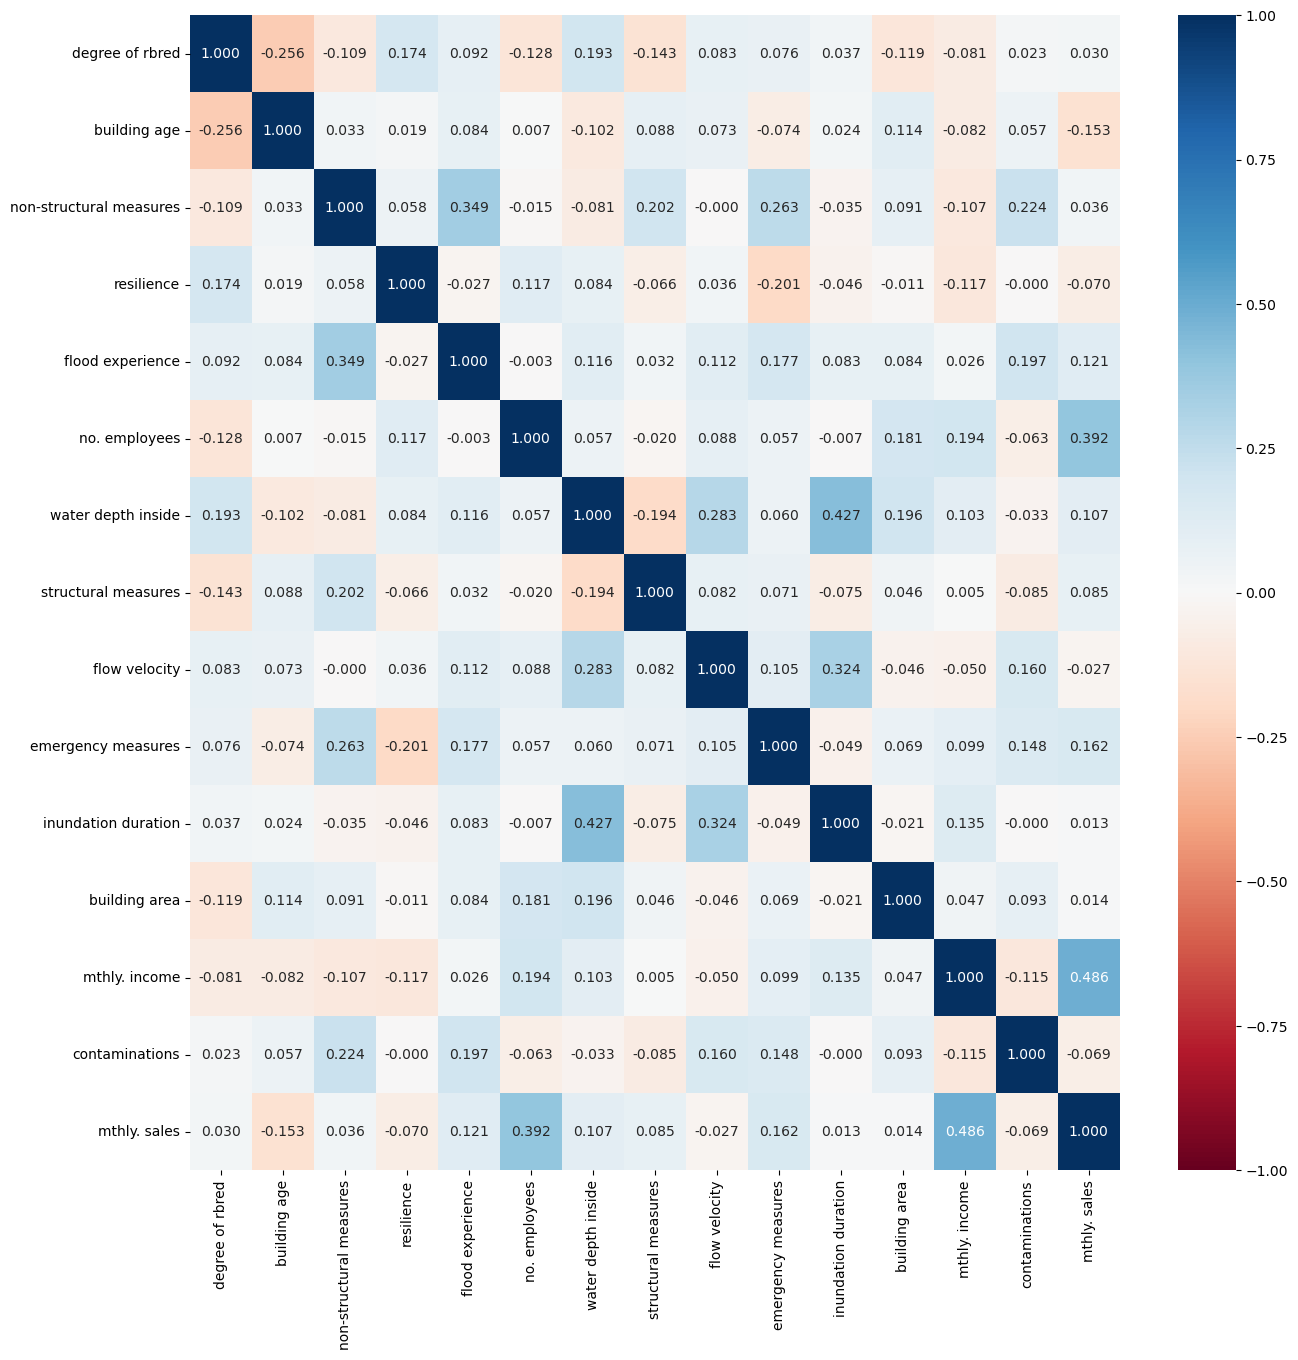

In [4]:
## find predictor with highest unconditional correlation to target_rbred
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc_d.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")


## Construct BN

In [5]:
df_hcmc_d.columns

Index(['degree of rbred', 'building age', 'non-structural measures',
       'resilience', 'flood experience', 'no. employees', 'water depth inside',
       'structural measures', 'flow velocity', 'emergency measures',
       'inundation duration', 'building area', 'mthly. income',
       'contaminations', 'mthly. sales'],
      dtype='object')

In [6]:
# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target_degree}"

# Define the variable names
# names_list = ["target_relative_contentloss_euro", "water_depth_cm", "b_area"]# inundation_duration_h
print(df_hcmc_d.columns)


# 'building age', 'non-structural measures', 'resilience', 'no. employees', 'flood experience']
names_list = [
    "degree of rbred", 
    "building age", 
    "water depth inside",
    "no. employees",
    "structural measures"
    # "non-structural measures"
   # "mthly. sales", "building age", #"flow velocity" #"precautionary_measures_lowcost"
   # "structural measures", "non-structural measures",
    # "resilience"
   # "no. employees", #"flow velocity"
    # "mthly. income"
    # "water_depth_cm", "precautionary_measures_lowcost", #"b_area", "emergency_measures"
    # "precautionary_measures_expensive", #"inundation_duration_h"
    ]



## Select the columns to use in the NPBN
# df_hcmc_d = df_hcmc_d[names_list]
df_hcmc_d = df_hcmc_d[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['degree of rbred', 'building age', 'non-structural measures',
       'resilience', 'flood experience', 'no. employees', 'water depth inside',
       'structural measures', 'flow velocity', 'emergency measures',
       'inundation duration', 'building area', 'mthly. income',
       'contaminations', 'mthly. sales'],
      dtype='object')
Using following features: {'degree of rbred': 0, 'building age': 1, 'water depth inside': 2, 'no. employees': 3, 'structural measures': 4}


5
[[1, 2, 3, 4], [], [1, 4], [], []]


<Figure size 500x500 with 0 Axes>

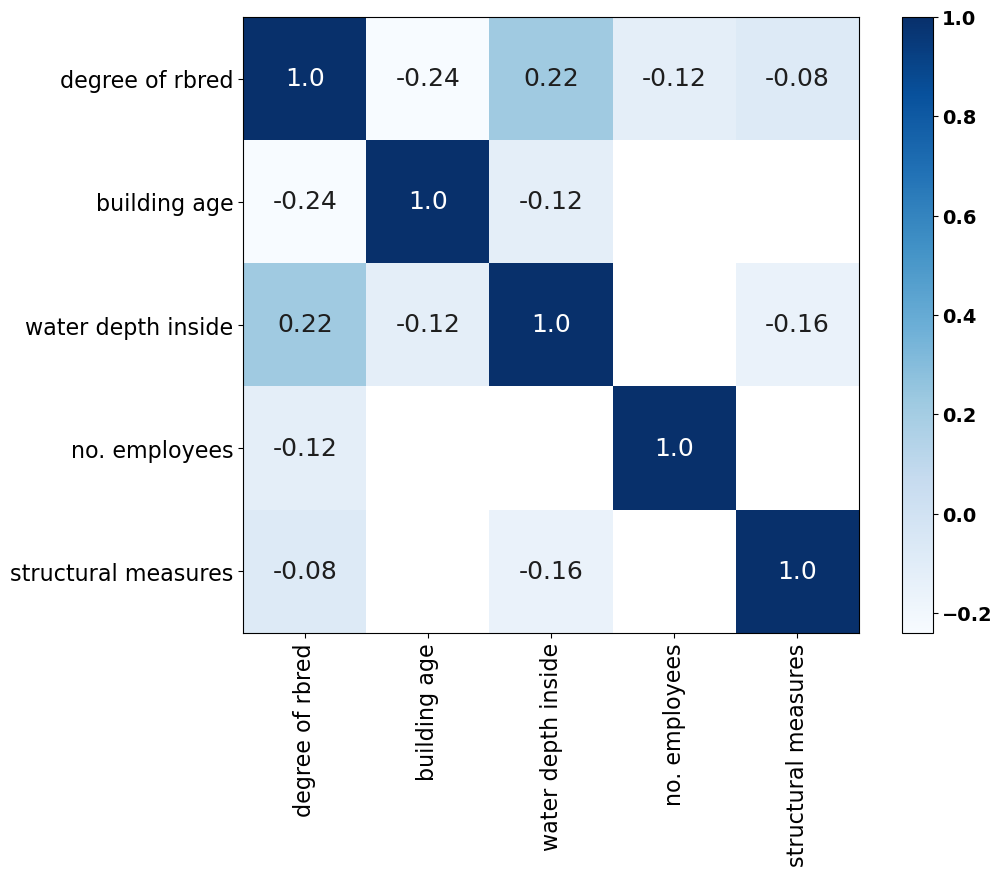

In [7]:
# Extract number of nodes from df_hcmc
N = df_hcmc_d.shape[1]  # number of nodes == number of features + target_degree
print(N)

# Defining the structure of the BN
parent_cell = [None]*N


# ### --- Schema kid_cell = parent_cells --- ###
parent_cell[0] = [1,2,3, 4] #, 3, 4, 5, 6]                                            #   target_degree (parents: all other features)
parent_cell[1] = []  
parent_cell[2] = [1, 4]
parent_cell[3] = []
parent_cell[4] = []

print(parent_cell)

#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_d,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

# The plot shows that target_degree has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.



### BN visualization

In [8]:
# # #-----------------------------------------------------------------------------
# # # Function 2 - bn_visualize - Plot of the Bayesian Network
# # #-----------------------------------------------------------------------------
# """BN structure with graph + rank correlations on degree of loss samples"""

# fig_name = f"./bn_structure_{target_degree}"

# print(df_hcmc_d.columns)

# df_hcmc_d_plot = df_hcmc_d # .rename(
#     # columns={
#     #     "mthly. sales": "mthly. sales",
#     #     "flowvelocity" : "flow velocity",
#     #     "water_depth_cm": "water depth inside",
#     #     "bage": "building age",
#     #     "target_relative_contentloss_euro" : "degree of rbred",
#     #     "precautionary_measures_lowcost": "non-structural measures", 
#     #     "precautionary_measures_expensive": "structural measures"
#     # })


# R = bn_rankcorr(parent_cell,        # structure of the BN
#             df_hcmc_d_plot,   # matrix of df_hcmc
#             var_names = names,  # names of variables
#             is_data = True,        # matrix data contains actual data
#             plot = True) 

# bn_visualize(parent_cell,           # structure of the BN
#              R,                     # the rank correlation matrix (function 1)
#              df_hcmc_d_plot.columns,          # names of variables
#              fig_name = fig_name)   # figure name
# # The plot presents the BN with x nodes and x arcs, with the (conditional)
# # rank correlations indicated on the arcs.

# bn_visualize(parent_cell,                       # structure of the BN
#              R,                                 # the rank correlation matrix 
#              df_hcmc_d_plot.columns,                      # names of variables
#              data = df_hcmc_d_plot,                       # DataFrame with data
#              fig_name = fig_name + "_margins")  # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs. In this plot also the marginal
# # distributions for each variable are incorporated.


### Copula test

In [9]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# M = cvm_statistic(df_hcmc_d,                   # df_predictorsFrame with df_hcmc
# #                   names = df_hcmc.columns,   # names of variables
#                   names = df_hcmc_d.columns,   # names of variables
#                   plot = True,               # create a plot (0=don"t create plot)
#                   fig_name = "empricial_corpula_all_vars_degree of rbred")    # figure name
#                                     # fig_name = fig_name)    # figure name

# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

In [10]:
# #-----------------------------------------------------------------------------
# # Function 4 - gaussian_distance - measuring d-calibration score
# #-----------------------------------------------------------------------------


# # gaussian_distance : validation: 
# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             df_hcmc_d,     # df_predictorsFrame with df_hcmc
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don"t create plot)
#                             Type="H",           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name


                   
# # draw 4000 samples of the normal distribution and perform 1000 iterations to
# # obtain the distribution of the d-cal score (ERC,NRC)
# # draw 400 samples of the normal distribution and perform 1000 iterations to
# # obtain the distribution of the d-cal score (NRC,BNRC)


# # The d-calibration score of the empirical rank correlation matrix is
# # inside the 90# confidence interval of the determinant of the empirical
# # The d-calibration score of the BN"s rank correlation matrix is well within  
# # the 90# confidence interval of the determinant of the random normal distribution 
# # sampled for the same correlation matrix. This supports the assumptions of
# # a joint normal copula used in the BN model. It should be noted that the 
# # test is sensitive to the number of samples drawn as well as the number of 
# # iterations and is rather severe for large df_predictorssets.


# Rbred estimation
- predict degree of loss on unseen samples of HCMC by consturcted BN
- load predictions of chance of loss (logistic regression)
- multiply degree with chance of loss


## predict degree of loss

In [11]:
## conditionalize BN on all parent nodes
condition = [1, 2, 3, 4]  # idx position of conditionalized varibales (all nodes except target)

assert df_hcmc_d.columns.to_list() == names_list, print("Update list of variables to conditionalize")
print(
    f"{target_degree} is predicted by following variables (parent nodes):\n", 
    {n:v for n,v in zip(condition, names_list)}
)


# setting for cross-validation
num_folds = 3
testset_size = int( len(df_hcmc_d) / num_folds  // 1)

# df_hcmc_d = df_hcmc_d#.sample(frac=1).reset_index(drop=True)
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
degree_results = pd.DataFrame()  # store y_true and y_pred 

print(f"all samples and variables used for entire CV: {df_hcmc_d.shape}")


for i in range(num_folds):

    # ## split Fold into train and test
    test_nth_fold = df_hcmc_d[i*testset_size:][:testset_size] # test samples in one fold
    train_nth_fold = df_hcmc_d[ ~df_hcmc_d.index.isin(test_nth_fold.index)] # train samples in one fold
    print(df_hcmc_d.shape , train_nth_fold.shape, test_nth_fold.shape)
    print(f"\ntraining and test samples for {i} fold: {train_nth_fold.shape[0], test_nth_fold.shape[0]}")

    values = test_nth_fold.iloc[:,condition].to_numpy() 
    values_idx = test_nth_fold.index  # sample positions used to rebuild DF after inference

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    ## predict target_degree
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        # DataFrame with df_hcmc
                Output="mean")    # type of output data
                #Output="median")    # type of output data
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.loc[:,target_degree].to_numpy()

    ## store for plotting obs ~ pred
    results_per_fold = pd.concat([pd.Series(y_true).round(2), pd.Series(y_pred).round(2)], axis=1)
    results_per_fold.index = values_idx
    degree_results = pd.concat([degree_results, results_per_fold], axis=0)  # DF with all obs+preds, sample idx from org. input DS: df_hcmc_d

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"\nScores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    # print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

# init df to store obs+predictions, use idx from DF degree
degree_results.columns = ["y_true", "y_pred"]


## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = OUTPATH_BN + f"./bn_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = OUTPATH_BN + f"./bn_avg_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)


# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


degree of rbred is predicted by following variables (parent nodes):
 {1: 'degree of rbred', 2: 'building age', 3: 'water depth inside', 4: 'no. employees'}
all samples and variables used for entire CV: (211, 5)
(211, 5) (141, 5) (70, 5)

training and test samples for 0 fold: (141, 70)

Scores from fold 0: 19.891532857142856 3.8882014285714277 24.5718180029858 36.26829571540891
(211, 5) (141, 5) (70, 5)

training and test samples for 1 fold: (141, 70)

Scores from fold 1: 22.331247142857144 2.605144285714284 31.250977410198132 32.74688089534212
(211, 5) (141, 5) (70, 5)

training and test samples for 2 fold: (141, 70)

Scores from fold 2: 23.478892857142853 2.4626328571428555 30.286300729073155 35.915343589837214
Averaged evaluation scores of k-fold cross-validation (mean) :
          MAE       MBE       RMSE     SMAPE
0  21.900558  2.985326  28.703032  34.97684 
..saved to ..\..\model_results\bayesian_network\degree_of_rbred\rbred./bn_performance_bn_degree_degree of rbred_hcmc.xlsx


In [12]:
print(degree_results.describe())


           y_true      y_pred
count  210.000000  210.000000
mean    31.219048   34.204000
std     25.643482   19.083585
min      1.000000   12.850000
25%     10.000000   24.742500
50%     20.000000   29.360000
75%     50.000000   34.065000
max    100.000000  100.100000


In [13]:
# assert all(degree_results.index == df_hcmc_incl_zero.loc[df_hcmc_incl_zero[target_rbred]> 0.0, target_rbred].index) == True, 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

### plot obs ~ pred

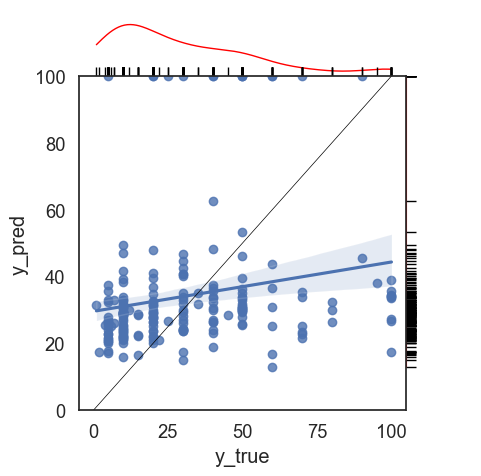

In [14]:
sns.set(style="white", font_scale=1.2)
g = sns.JointGrid(
    x=degree_results["y_true"], y=degree_results["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

In [15]:
# bins = np.linspace(0, 100, 100)

# plt.hist(results["y_true"], bins, alpha=0.7, label="empirical")
# plt.hist(results["y_pred"], bins, alpha=0.7, label="predicted")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for degree of loss for HCMC")
# plt.xlim(0,100)
# plt.show()


### get uncertainty in predictions of degree of rbred

In [16]:
condition = condition 
values = df_hcmc_d.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_hcmc_d,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_hcmc_d.iloc[:,0].to_numpy()



In [17]:
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

df_uncertainties_avg = df_uncertainties

df_uncertainties_p = pd.DataFrame()
df_uncertainties_p["avg_modelled"] = df_uncertainties_avg.mean(axis=0)
df_uncertainties_p["observed"] = y_true
df_uncertainties_p["city"] = "HCMC"

df_uncertainties_p


,avg_modelled,observed,city
0,26.9347,20,HCMC
1,15.9460,5,HCMC
2,19.8299,10,HCMC
3,33.4964,30,HCMC
4,26.3635,10,HCMC
...,...,...,...
206,27.3522,20,HCMC
207,33.6479,30,HCMC
208,38.9337,30,HCMC
209,27.0819,10,HCMC


In [18]:
degree_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 6 to 357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_true  210 non-null    int64  
 1   y_pred  210 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.9 KB


## load estimates of chance of loss - HCMC
get predicted probabilities form Logistic Regression, estimates are returned from nested cv , these are the predictions done on the outer test sets

In [19]:
## load estimated probabilities for chance of loss from ncv
df_hcmc_c  = pd.read_excel(OUTPATH_CHANCE + f"./predictions_chance_of_rbred.xlsx")
#df_hcmc_c  = pd.read_excel("predictions_chance_of_rbred.xlsx")
 # f"predictions_target_relative_contentloss_euro.xlsx")
print(df_hcmc_c.shape)

##  update probability column in respect to y_pred, 
## currently zero-loss cases have also probability between 0.5 - 1.0 % --> should be 0.0 - 0.49 %: if ypred == 0 --> then proba should be 1.0 -> 0.0 ; 0.98 -> 0.02  [old proba -> new proba]
df_hcmc_c = eu.reverse_probability_scores(df_hcmc_c, "y_proba", ("y_pred", 0.0))

# set index the same as for df_hcmc_pred_cd
df_hcmc_c = df_hcmc_c.set_index("Unnamed: 0")
df_hcmc_c.index.name = None

df_hcmc_c#["y_proba"]#.describe()


(313, 6)


,y_true,y_pred,y_proba,residual,y_true_rbred
0,0,0,0.355,0,0.0
1,0,0,0.358,0,0.0
2,0,0,0.333,0,0.0
3,0,0,0.360,0,0.0
4,0,0,0.320,0,0.0
...,...,...,...,...,...
355,1,1,0.678,0,30.0
356,1,1,0.628,0,30.0
357,1,1,0.757,0,10.0
358,1,1,0.510,0,NaN


In [20]:

## add chance of loss as column to results df
df_hcmc_pred_cd["chance of rbred"] = df_hcmc_pred_cd["rbred"]
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["chance of rbred"] > 0.0, "chance of rbred"] = 1.0
df_hcmc_pred_cd[pred_target_chance]= 0.0 ## NOTE keep as 0.0 to join with floats of y_pred, otherwise multiplcation with degree of rbred does not work
df_hcmc_pred_cd[f"{pred_target_chance}_binary"]= None 

df_hcmc_pred_cd[pred_target_chance][df_hcmc_c.index.tolist()] = df_hcmc_c["y_proba"] # add predicted probabilities for chance of loss to common df (which later also incl. degree of loss)
df_hcmc_pred_cd[f"{pred_target_chance}_binary"][df_hcmc_c.index.tolist()] = df_hcmc_c["y_pred"] #  add predicted binary values for chance of loss to common df (which later also incl. degree of loss)

#df_hcmc_pred_cd[f"predicted chance of closs"]
df_hcmc_pred_cd.describe()#[f"chance_pred_proba"]

,rbred,building age,non-structural measures,resilience,flood experience,no. employees,water depth inside,structural measures,flow velocity,emergency measures,inundation duration,building area,mthly. income,contaminations,mthly. sales,chance of rbred,pred_chance of rbred
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,17.814696,20.143770,0.378594,2.605431,82.738019,1.894569,33.744409,0.230032,0.308626,0.422790,11.264217,86.020767,433.674760,0.980831,378.858147,0.594249,0.602351
std,24.276271,14.525898,0.300302,1.070467,53.414577,1.260241,25.905372,0.274082,0.127685,0.262478,29.322452,89.281120,376.684503,0.391762,463.066786,0.491823,0.158587
min,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.100000,0.000000,0.200000,12.000000,18.400000,0.000000,92.100000,0.000000,0.237000
25%,0.000000,12.000000,0.250000,1.750000,36.000000,1.000000,10.000000,0.000000,0.200000,0.166667,2.000000,42.000000,294.600000,1.000000,92.100000,0.000000,0.493000
50%,10.000000,18.000000,0.250000,2.500000,76.000000,2.000000,30.000000,0.000000,0.300000,0.500000,3.000000,74.000000,294.600000,1.000000,276.200000,1.000000,0.622000
75%,30.000000,25.000000,0.500000,3.500000,151.000000,2.000000,50.000000,0.500000,0.400000,0.666667,6.000000,100.000000,552.400000,1.000000,276.200000,1.000000,0.727000
max,100.000000,100.000000,1.000000,5.000000,151.000000,9.000000,150.000000,1.000000,0.500000,1.000000,240.000000,850.000000,3314.300000,2.000000,2761.900000,1.000000,0.948000


In [21]:
# plt.hist(df_hcmc_c_pred.dropna(), bins, alpha=0.5, label="predicted (as binary)")  
# # FIXME NOTE skip last two samples due that they were not used for cross-validating BN
# # df_hcmc_c_pred.astype("Int64")[:-2].describe()

Actual zero-loss: 127 
Actual damage: 186 

Predict as zero-loss: 82 
Predict as damage: 231 


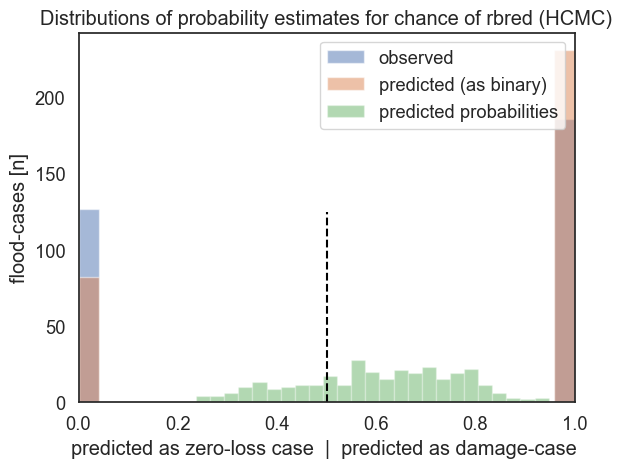

In [22]:
df_hcmc_c_pred = df_hcmc_pred_cd[f"{pred_target_chance}_binary"]
df_hcmc_c_proba = df_hcmc_pred_cd[pred_target_chance]
df_hcmc_c_true = df_hcmc_pred_cd["chance of rbred"]

print(f"Actual zero-loss: {len(np.where(df_hcmc_c_true == 0)[0])} \nActual damage: {df_hcmc_c_true[df_hcmc_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_hcmc_c_pred == 0)[0])} \nPredict as damage: {len(np.where(df_hcmc_c_pred == 1)[0])} ")

bins = np.linspace(0, 1, 25)
plt.hist(df_hcmc_c_true, bins, alpha=0.5, label="observed")
plt.hist(df_hcmc_c_pred.dropna(), bins, alpha=0.5, label="predicted (as binary)")  # FIXME NOTE skip NA samples
plt.hist( df_hcmc_c_proba, 25, alpha=0.3, label="predicted probabilities", color="green")
plt.legend(loc="upper right")
plt.title("Distributions of probability estimates for chance of rbred (HCMC)")
plt.xlim(0,1)
plt.ylabel("flood-cases [n]")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")

plt.xlabel("predicted as zero-loss case  |  predicted as damage-case ")
plt.show()


In [23]:
df_hcmc_c_proba.describe()

count    313.000000
mean       0.602351
std        0.158587
min        0.237000
25%        0.493000
50%        0.622000
75%        0.727000
max        0.948000
Name: pred_chance of rbred, dtype: float64

## get relative content loss estimations (chance * degree of loss)

**merge dfs for degree of rbred with chance of rbred **

In [24]:
## index of complete damage cases (no zero-losses and no incomplete cases)
# # FIXME NOTE skip last sample of "degree of loss" due that it was not used for cross-validating BN
idx_damage = df_hcmc_d.loc[~df_hcmc_incl_zero.isnull().any(axis=1)].index[:-1]


## fill dummy df with degree of rbred cases
## new col incl prediction of degree of loss, all zero-losse cases are set as 0 
df_hcmc_pred_cd[pred_target_degree] =  0.0   # new col for rbred predictions
df_hcmc_pred_cd[pred_target_degree][idx_damage] = degree_results["y_pred"][idx_damage]
#df_hcmc_pred_cd.loc[idx_damage, pred_target_degree] = degree_results["y_pred"]

# store observed degree of rbred
df_hcmc_pred_cd["degree"] = np.nan
df_hcmc_pred_cd["degree"][idx_damage] = degree_results["y_true"][idx_damage] #

# store predictions of degree of loss for later 
df_hcmc_pred_cd["degree_pred"] = np.nan
df_hcmc_pred_cd["degree_pred"][idx_damage] = degree_results["y_pred"][idx_damage] # new col for degree of loss predictions from BN,  only for evaluation if damage-cases were assigned correctly
df_hcmc_pred_cd["degree_pred"].describe()

count    185.000000
mean      29.288108
std        7.488206
min       12.850000
25%       23.980000
50%       28.880000
75%       33.090000
max       62.720000
Name: degree_pred, dtype: float64

In [25]:
df_hcmc_pred_cd[pred_target_degree].describe() #* df_hcmc_pred_cd[f"chance_pred_proba"] 
# df_hcmc_pred_cd.describe()

count    313.000000
mean      17.310863
std       15.526423
min        0.000000
25%        0.000000
50%       22.210000
75%       29.900000
max       62.720000
Name: pred_degree of rbred, dtype: float64

In [26]:
# ## bn_degree_true_pred  # degree of damages
# ## y_cantho_proba_damage # chance that instance is a damage-case


# ## get estimation of relative content loss
# # y_pred_rbred = df_hcmc_pred_cd[pred_target_degree] * df_hcmc_c["y_proba"].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# # y_pred_rbred = bn_degree_true_pred["y_pred"] * y_hcmc_chance_proba[0].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# ## add zero-loss cases
# y_pred_rbred = y_pred_rbred.fillna(0.0)
# y_pred_rbred


## get estimation of relative content loss
df_hcmc_pred_cd[pred_target_rbred] = np.nan# init col for rbred
df_hcmc_pred_cd[pred_target_rbred] = df_hcmc_pred_cd[pred_target_degree] * df_hcmc_pred_cd[pred_target_chance]  # risk = damage [%] * chance [0,1]
df_hcmc_pred_cd[pred_target_rbred].describe()

print(df_hcmc_pred_cd.columns)
df_hcmc_pred_cd[[target_rbred, pred_target_rbred, pred_target_degree, pred_target_chance]] = df_hcmc_pred_cd[[target_rbred, pred_target_rbred, pred_target_degree, pred_target_chance]].astype(float)
df_hcmc_pred_cd[[target_rbred, pred_target_rbred, pred_target_degree, pred_target_chance]].describe()


Index(['rbred', 'building age', 'non-structural measures', 'resilience',
       'flood experience', 'no. employees', 'water depth inside',
       'structural measures', 'flow velocity', 'emergency measures',
       'inundation duration', 'building area', 'mthly. income',
       'contaminations', 'mthly. sales', 'chance of rbred',
       'pred_chance of rbred', 'pred_chance of rbred_binary',
       'pred_degree of rbred', 'degree', 'degree_pred', 'pred_rbred'],
      dtype='object')


,rbred,pred_rbred,pred_degree of rbred,pred_chance of rbred
count,313.000000,313.000000,313.000000,313.000000
mean,17.814696,11.047864,17.310863,0.602351
std,24.276271,10.817745,15.526423,0.158587
min,0.000000,0.000000,0.000000,0.237000
25%,0.000000,0.000000,0.000000,0.493000
50%,10.000000,10.567800,22.210000,0.622000
75%,30.000000,19.838480,29.900000,0.727000
max,100.000000,42.576000,62.720000,0.948000


# Rbred evaluation - HCMC

In [27]:
df_hcmc_pred_cd[[target_rbred, pred_target_rbred]]

df_hcmc_pred_cd[[pred_target_degree,pred_target_chance]].describe()

,pred_degree of rbred,pred_chance of rbred
count,313.000000,313.000000
mean,17.310863,0.602351
std,15.526423,0.158587
min,0.000000,0.237000
25%,0.000000,0.493000
50%,22.210000,0.622000
75%,29.900000,0.727000
max,62.720000,0.948000


In [28]:
# evaluation metrics
MAE = eu.mean_absolute_error(df_hcmc_pred_cd[target_rbred], df_hcmc_pred_cd[pred_target_rbred]).round(3)
MBE = eu.mean_bias_error(df_hcmc_pred_cd[target_rbred], df_hcmc_pred_cd[pred_target_rbred]).round(3)
RMSE = eu.root_mean_squared_error(df_hcmc_pred_cd[target_rbred], df_hcmc_pred_cd[pred_target_rbred]).round(3) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(df_hcmc_pred_cd[target_rbred], df_hcmc_pred_cd[pred_target_rbred]).round(3)


print(f"MAE: {MAE}, \nMBE: {MBE}, \nRMSE: {RMSE}, \nSMAPE: {SMAPE}")  

eu.empirical_vs_predicted(df_hcmc_pred_cd[target_rbred], df_hcmc_pred_cd[pred_target_rbred])

MAE: 11.286, 
MBE: -6.767, 
RMSE: 20.847, 
SMAPE: 21.035


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,313,10.0,17.814696,"[0, 100]",589.34,24.24,136.271035
predicted,313,10.0,10.766773,"[0, 42]",112.54,10.59,98.529157


### Plot obs ~ pred


In [29]:
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["rbred"]>0.0, "rbred"].describe()

count    186.000000
mean      29.978495
std       25.045679
min        1.000000
25%       10.000000
50%       20.000000
75%       40.000000
max      100.000000
Name: rbred, dtype: float64

In [30]:
# df_hcmc_pred_cd#["rbred"].value_counts()
df_hcmc_c#.describe(
# df_hcmc_pred_cd#["rbred"],


df_hcmc_pred_cd["pred_rbred_binary"] = np.nan
df_hcmc_pred_cd["pred_rbred_binary"] = df_hcmc_pred_cd["pred_rbred"] 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["pred_rbred_binary"] > 0.0 , "pred_rbred_binary"]= 1.0
df_hcmc_pred_cd.describe()


df_hcmc_pred_cd["obs_rbred_binary"] = np.nan
df_hcmc_pred_cd["obs_rbred_binary"] = df_hcmc_pred_cd["rbred"] 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["obs_rbred_binary"] > 0.0 , "obs_rbred_binary"]= 1.0
df_hcmc_pred_cd.describe()

,rbred,building age,non-structural measures,resilience,flood experience,no. employees,water depth inside,structural measures,flow velocity,emergency measures,inundation duration,building area,mthly. income,contaminations,mthly. sales,chance of rbred,pred_chance of rbred,pred_degree of rbred,degree,degree_pred,pred_rbred,pred_rbred_binary,obs_rbred_binary
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,185.000000,185.000000,313.000000,313.000000,313.000000
mean,17.814696,20.143770,0.378594,2.605431,82.738019,1.894569,33.744409,0.230032,0.308626,0.422790,11.264217,86.020767,433.674760,0.980831,378.858147,0.594249,0.602351,17.310863,30.086486,29.288108,11.047864,0.591054,0.594249
std,24.276271,14.525898,0.300302,1.070467,53.414577,1.260241,25.905372,0.274082,0.127685,0.262478,29.322452,89.281120,376.684503,0.391762,463.066786,0.491823,0.158587,15.526423,25.070186,7.488206,10.817745,0.492426,0.491823
min,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.100000,0.000000,0.200000,12.000000,18.400000,0.000000,92.100000,0.000000,0.237000,0.000000,1.000000,12.850000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,0.250000,1.750000,36.000000,1.000000,10.000000,0.000000,0.200000,0.166667,2.000000,42.000000,294.600000,1.000000,92.100000,0.000000,0.493000,0.000000,10.000000,23.980000,0.000000,0.000000,0.000000
50%,10.000000,18.000000,0.250000,2.500000,76.000000,2.000000,30.000000,0.000000,0.300000,0.500000,3.000000,74.000000,294.600000,1.000000,276.200000,1.000000,0.622000,22.210000,20.000000,28.880000,10.567800,1.000000,1.000000
75%,30.000000,25.000000,0.500000,3.500000,151.000000,2.000000,50.000000,0.500000,0.400000,0.666667,6.000000,100.000000,552.400000,1.000000,276.200000,1.000000,0.727000,29.900000,40.000000,33.090000,19.838480,1.000000,1.000000
max,100.000000,100.000000,1.000000,5.000000,151.000000,9.000000,150.000000,1.000000,0.500000,1.000000,240.000000,850.000000,3314.300000,2.000000,2761.900000,1.000000,0.948000,62.720000,100.000000,62.720000,42.576000,1.000000,1.000000


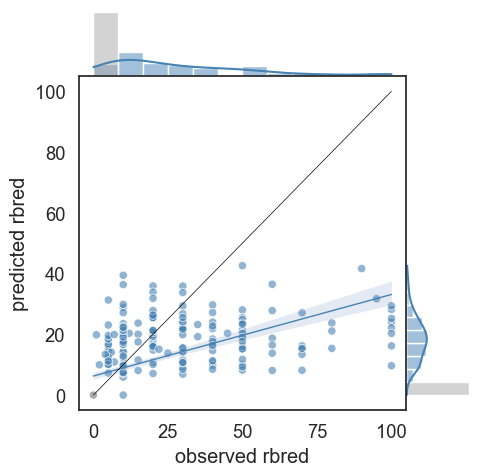

In [31]:
f.plot_observed_predicted(
    y_true=df_hcmc_pred_cd["rbred"], y_pred=df_hcmc_pred_cd["pred_rbred"], 
    # hue=df_hcmc_pred_cd["pred_rbred_binary"], # pred chance of loss - binary
    hue=df_hcmc_pred_cd["obs_rbred_binary"], 
    xlabel=f"observed rbred", ylabel=f"predicted rbred",  #  target="degree of rbred",
    legend=False ,#True
    outfile="tst" #OUTPATH_BN + f"./scatter_obs_pred_rbred_hcmc.png"
)     


### Main validation results

In [32]:
# ## get damage ratio in respect to total number of cases
# c = "y_pred"
# print(len(np.where(rbred_pred > 0.0)[0])) 
# print(len(np.where(rbred_pred > 0.0)[0]) / len(rbred_true) * 100, "%")
# np.mean(rbred_true)

## get ratio of damage cases vs total reported bred
c = df_hcmc_pred_cd["rbred"]
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


186
59.424920127795524 %


17.814696485623003

In [33]:
residuals_hcmc = pd.DataFrame(
            {
                "y_true": df_hcmc_pred_cd["rbred"],
                "y_pred":  df_hcmc_pred_cd["pred_rbred"],
                "residual": df_hcmc_pred_cd["pred_rbred"] - df_hcmc_pred_cd["rbred"],
            },
            index=df_hcmc_pred_cd["rbred"].index,
        )
print(residuals_hcmc.describe())


for c in residuals_hcmc.columns:
    ci = eu.calc_confidence_interval(residuals_hcmc[c], confidence_level=0.95)

eu.empirical_vs_predicted(df_hcmc_pred_cd["rbred"], df_hcmc_pred_cd["pred_rbred"])

           y_true      y_pred    residual
count  313.000000  313.000000  313.000000
mean    17.814696   11.047864   -6.766833
std     24.276271   10.817745   19.749852
min      0.000000    0.000000  -90.351460
25%      0.000000    0.000000   -8.839700
50%     10.000000   10.567800    0.000000
75%     30.000000   19.838480    0.000000
max    100.000000   42.576000   29.424610
confidence interval: (15.114807830286932, 20.514585140959074) 
cases within interval: 26
confidence interval: (9.844766814894008, 12.250960597246568) 
cases within interval: 20
confidence interval: (-8.963315132041057, -4.570350427064377) 
cases within interval: 10


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,313,10.0,17.814696,"[0, 100]",589.34,24.24,136.271035
predicted,313,10.0,10.766773,"[0, 42]",112.54,10.59,98.529157


In [34]:

confidence_level=0.95

for c in residuals_hcmc.columns:
    
    conf_interval = stats.t.interval(0.95, len(residuals_hcmc[c])-1, loc=np.mean(residuals_hcmc[c]), scale=stats.sem(residuals_hcmc[c]))
    counts = ((residuals_hcmc[c] > conf_interval[0]) & (residuals_hcmc[c] <= conf_interval[1])).sum(axis=0)
    print("confidence interval:", conf_interval, f"\ncases within interval: {counts}")



confidence interval: (15.114807830286932, 20.514585140959074) 
cases within interval: 26
confidence interval: (9.844766814894008, 12.250960597246568) 
cases within interval: 20
confidence interval: (-8.963315132041057, -4.570350427064377) 
cases within interval: 10


#### Plot residuals
Plot observation vs residuals

In [35]:
from matplotlib.colors import to_rgba

def plot_residuals_single(x, y, hue_group=None):

    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

    hue_colors=("darkgrey","steelblue")
    alpha=0.7

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    ax.axhline(0, ls='--')
    sns.scatterplot(
        x = x, 
        y = y, # pred - obs 
        hue = hue_group,
        color = "steelblue",
        alpha = 0.5,
        #hue=df_hcmc_abred["abs_bred_true_dummy"]
        palette=color_dict, edgecolors=color_dict
    )
    plt.xlabel("observation")
    plt.ylabel("residuals (prediction - observation)")


**test residuals grouped by sales / sector**

In [36]:
df_hcmc_pred_cd.describe()
# 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth inside"] < 30, :]

,rbred,building age,non-structural measures,resilience,flood experience,no. employees,water depth inside,structural measures,flow velocity,emergency measures,inundation duration,building area,mthly. income,contaminations,mthly. sales,chance of rbred,pred_chance of rbred,pred_chance of rbred_binary,pred_degree of rbred,degree,degree_pred,pred_rbred,pred_rbred_binary,obs_rbred_binary
0,0.0,12.0,0.00,5.00,76,1,10.0,0.0,0.2,0.000000,2.0,25.0,110.5,0,276.2,0,0.355,0,0.00,NaN,NaN,0.00000,0.0,0.0
1,0.0,0.0,0.00,5.00,76,1,15.0,0.0,0.2,0.000000,2.0,21.0,294.6,1,276.2,0,0.358,0,0.00,NaN,NaN,0.00000,0.0,0.0
2,0.0,21.0,0.75,3.50,76,1,2.0,0.5,0.2,0.000000,1.0,50.0,552.4,0,92.1,0,0.333,0,0.00,NaN,NaN,0.00000,0.0,0.0
3,0.0,20.0,0.25,4.00,16,1,5.0,0.5,0.3,0.000000,3.0,80.0,294.6,1,92.1,0,0.360,0,0.00,NaN,NaN,0.00000,0.0,0.0
4,0.0,20.0,0.50,3.50,3,1,3.0,0.5,0.2,0.000000,0.5,55.0,552.4,0,276.2,0,0.320,0,0.00,NaN,NaN,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.0,18.0,0.00,1.00,76,6,15.0,0.5,0.2,0.000000,3.0,96.0,920.6,1,276.2,0,0.336,0,0.00,NaN,NaN,0.00000,0.0,0.0
338,0.0,14.0,0.75,2.25,76,1,10.0,0.5,0.1,0.000000,0.5,70.0,110.5,0,92.1,0,0.292,0,0.00,NaN,NaN,0.00000,0.0,0.0
344,0.0,6.0,0.00,2.00,76,2,5.0,0.0,0.3,0.166667,30.0,28.0,552.4,0,276.2,0,0.501,1,0.00,NaN,NaN,0.00000,0.0,0.0
347,40.0,8.0,0.25,2.75,36,2,10.0,0.0,0.2,0.000000,2.0,80.0,110.5,1,92.1,1,0.368,0,23.13,40.0,23.13,8.51184,1.0,1.0


(313, 3)


(238, 25)


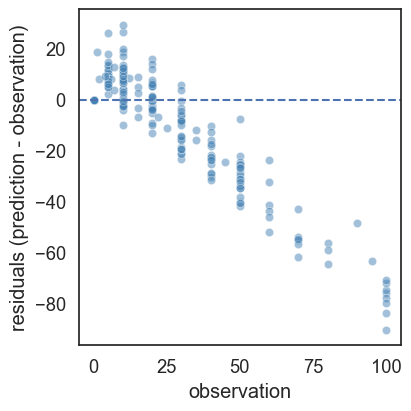

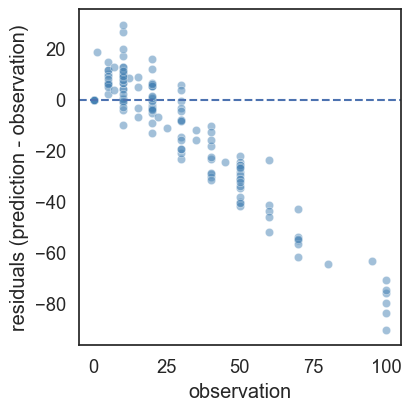

In [37]:
print(residuals_hcmc.shape)
plot_residuals_single(residuals_hcmc["y_true"], residuals_hcmc["residual"])

residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["mthly. sales"] < 300, :]
# residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth inside"] > 30, :]
#residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth inside"] < 30, :]
residuals_hcmc_subset["residual"] = df_hcmc_pred_cd["pred_rbred"] - df_hcmc_pred_cd["rbred"]
print(residuals_hcmc_subset.shape)
plot_residuals_single(residuals_hcmc_subset["rbred"], residuals_hcmc_subset["residual"])

## tested groups
## --> wd: when wd > 30m and sm losses occured than they are rather predictedoverestiated by the model (compared to residuals based on all samples)
##      wd < 30 and small losses are predicted with small bias
## --> sales: the flood cases with middle and higher sales are quite well predicted as long as their losses are under 25%, 
## lower sales even with lower loss ratios have relatively higher prediction bias

Text(0, 0.5, 'residuals (prediction - observation)')

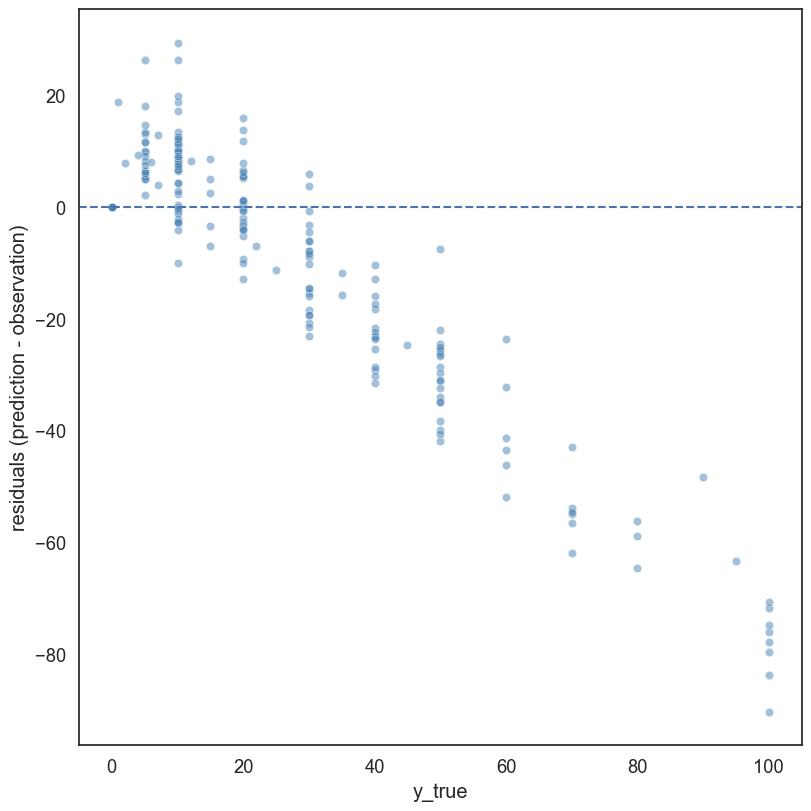

In [38]:
residuals_hcmc.describe()

from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x=residuals_hcmc.y_true, 
    y=residuals_hcmc.residual,
    color="steelblue", alpha=0.5
    #hue=df_hcmc_adegree["abs_degree_true_dummy"]
    #palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")


### Absolute content loss


In [39]:
# # df_hcmc_pred_cd[target_degree]
# df_hcmc_pred_cd[target_rbred].describe()

In [40]:
# assert df_hcmc_d[target_degree].all() == df_hcmc_pred_cd[target_degree].all(), "fix upper code were y_true is shuffled - residual df should have the same order as when it was loaded"

In [41]:
# ##  get first abs loss of only damage cases (only BN results) due that rbred cases are all multiplied by chance of loss
# df_hcmc_acloss = df_hcmc_pred_cd.copy()

# ## use true reported abs closs from survey
# df_hcmc_acloss["acloss"] = df_hcmc_acloss["closs"] #df_hcmc_acloss[target_degree] *  df_hcmc_acloss["shp_content_value_euro"] / 100 

# ## NOTE use here vulnerability rbred (BN*chance)
# df_hcmc_acloss["pred_acloss"] = np.nan
# df_hcmc_acloss["pred_acloss"] = df_hcmc_acloss[pred_target_degree] *  df_hcmc_acloss["shp_content_value_euro"] / 100 
# ## NOTE use here BN result (degree of loss)
# # df_hcmc_acloss["abs_degree_pred"] = df_hcmc_acloss["degree_pred"] *  df_hcmc_acloss["shp_content_value_euro"] / 100 
# # print("abs_degree_pred has no zero-loss cases (min=", round(df_hcmc_acloss["abs_degree_pred"].min(),2), ") and", df_hcmc_acloss.shape[0],"damage cases")


# # ## keep only damage cases to calc abs. degree of loss
# # print("check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables")
# # assert df_hcmc_acloss.acloss[df_hcmc_acloss["acloss"] > 0.0].index.all() == df_hcmc_acloss.abs_degree_pred[df_hcmc_acloss["abs_degree_pred"] > 0.0].index.all(), "not same idx in obs and pred degree of loss"

# # df_hcmc_adegree = pd.DataFrame(columns=["abs_degree_true", "abs_degree_pred", "mthly. sales"]).reset_index(drop=True)
# # df_hcmc_adegree["abs_degree_true"] = df_hcmc_acloss["acloss_true"][df_hcmc_acloss["acloss_true"] > 0.0]
# # df_hcmc_adegree["abs_degree_pred"] = df_hcmc_acloss["abs_degree_pred"][df_hcmc_acloss["acloss_true"] > 0.0]  # remove all np.nan in "abs_degree_pred" (these are the zero-loss cases) by using idx from obs. zero-loss
# # df_hcmc_adegree["mthly. sales"] = df_hcmc_acloss["mthly. sales"][df_hcmc_acloss["acloss_true"] > 0.0] 


# # ## add dummy binary var for plotting
# # df_hcmc_adegree["abs_degree_true_dummy"] =  1.0   


# print("\nHCMC: absolute content loss")
# eu.empirical_vs_predicted(df_hcmc_acloss["acloss"], df_hcmc_acloss["pred_acloss"])

# # print("\nHCMC: absolute degree of content loss (only damage cases)")
# # eu.empirical_vs_predicted(df_hcmc_adegree["abs_degree_true"], df_hcmc_adegree["abs_degree_pred"])

# ## HCMC abs degree of loss
# # #	       nobs	median	mean	    min max	   variance	standard deviation	coef variation
# # empirical	114	117.0	352.517544	[7, 3618]	347977.77	587.30	        167.338171
# # predicted	114	352.5	575.140351	[19, 6483]	812338.46	897.34	        156.709263

Notes to  abs loss
- obs and pred mean are quite similar, underestimate higher losses

In [42]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# # from matplotlib.cbook import boxplot_stats  
# from matplotlib.colors import to_rgba

# def plot_observed_predicted_abs(y_true, y_pred, hue=None, hue_colors=("darkgrey","steelblue"), xlabel="observed", ylabel="predicted",  alpha=0.6, legend=False, outfile="test.png"):
#     """
#     Scatter plot of observations vs predictions with optional class colors
#     NOTE: hue is currently limited to binary cases
#     # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue
#     """

#     sns.set(style="white", font_scale=1.2)

#     color_dict = {
#         0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
#         1: to_rgba(hue_colors[1], alpha)
#     }

#     if hue is None:
#         color_dict = color_dict[1]

#     g = sns.JointGrid(
#         x=y_true, y=y_pred, hue=hue,
#         height=5, space=0,)
#     # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
#     p = sns.scatterplot(
#         x=y_true, y=y_pred, hue=hue, 
#         palette=color_dict, edgecolors=color_dict, legend=legend, 
#         ax=g.ax_joint)
    
#     if legend is True:
#         #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
#         plt.setp(p.get_legend().get_texts(), fontsize='12')  
#         plt.setp(p.get_legend().get_title(), fontsize='15')

#     g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

#     g1 = sns.regplot(
#         x=y_true, y=y_pred, 
#         line_kws={"lw":1.},
#         scatter=False, ax=g.ax_joint)
#     regline = g1.get_lines()[0]
#     regline.set_color('steelblue')

#     x0, x1 = (0, 100) 
#     y0, y1 = (0, 100)
#     lims = [min(x0, y0), max(x1, y1)]
#     g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
#     g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
#     # plt.title(f"Observed and predicted {target}")
    
#     # save plot
#     plt.savefig( outfile, dpi=300, bbox_inches="tight")

#     plt.show()
#    # plt.close()


In [43]:
# ## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 

# plot_observed_predicted_abs(
#     y_true=df_hcmc_acloss["acloss"], y_pred=df_hcmc_acloss["pred_acloss"], 
#     hue=df_hcmc_acloss["pred_chance of rbred_binary"],
#     xlabel=f"observed closs [€]", ylabel=f"predicted closs [€]", #target="acloss",
#     legend=False ,#True
#     outfile=OUTPATH_BN + f"./scatter_obs_pred_abs_closs_{target_plot}_hcmc.png"
# ) 

# # plot_observed_predicted_abs(
# #     y_true=df_hcmc_adegree["abs_degree_true"], y_pred=df_hcmc_adegree["abs_degree_pred"], 
# #     hue=df_hcmc_adegree["abs_degree_true_dummy"],
# #     xlabel=f"observed abs. degree of closs [€]", ylabel=f"predicted abs. degree of closs [€]",
# #     legend=False ,#True
# #     outfile=OUTPATH_BN + f"./scatter_obs_pred_abs_degree_{target_plot}_hcmc.png"
# # )     


In [44]:


# # ### Plot prediction error from outer cv
# f.plot_results(
#     results=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../model_results/models_evaluation/degree_of_loss/results_{target_degree}.png"
# )


In [45]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_d[target_degree], bins, alpha=0.5, label="hcmc rbred")
# plt.hist(df_cantho[target_degree], bins, alpha=0.5, label="cantho rbred")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for both cities (empirical)")
# plt.show()


#### Model - observations

In [46]:
# # plot_boxplot_scatterplot(df_hcmc_adegree, group, column, scatterpoints)
# # df_hcmc_acloss["diff_pred_vs_obs"] = df_hcmc_acloss[pred_target_degree] - df_hcmc_acloss[target_degree]
# df_hcmc_acloss["diff_pred_vs_obs"] = df_hcmc_acloss[pred_target_degree] - df_hcmc_acloss[target_degree]
# sns.boxplot(x=df_hcmc_acloss["diff_pred_vs_obs"] )

# # sns.boxplot(
# #    # x=df_hcmc_pred_cd[target_degree][df_hcmc_pred_cd[target_degree]>0.0]
# #    x=df_hcmc_pred_cd[pred_target_degree][df_hcmc_pred_cd[pred_target_degree]>0.0]
# # )



# Model transferability
Test trained NPBN for CanTHo DS

In [81]:
## load cantho predictors
infile_name = "input_data_businessreduction_cantho"
df_cantho_incl_zero = pd.read_excel(f"../../input_survey_data/{infile_name}.xlsx")

##  use nice feature names
df_cantho_incl_zero.rename(columns=s.feature_names_plot, inplace=True) 

print(df_cantho_incl_zero[target_rbred].describe())

## load classifier for chance of loss
# clf_file = "LogisticRegression_target_relative_contentloss_euro"
clf_file = "LogisticRegression_chance of rbred"
clf_filepath = OUTPATH_FINALMODELS_CHANCE + f"./{clf_file}.joblib"
# \models_trained\final_models\chance_of_rbred\rbred
clf = load(clf_filepath) 
clf


count    313.000000
mean      40.862620
std       21.850827
min        0.000000
25%       25.000000
50%       40.000000
75%       50.000000
max      100.000000
Name: rbred, dtype: float64


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1, l1_ratio=1.0, max_iter=500,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=0.001))])

In [82]:
# LogReg or RF cant predict on incomplete records
#pp.percentage_of_nan(df_cantho_incl_zero)
# df_cantho_incl_zero = df_cantho_incl_zero.dropna() 
# df_hcmc_incl_zero.drop(["closs", "geometry", "shp_content_value_euro"], axis=1).dropna()

In [83]:
## get same index for chance and degree df to multiply them later based on ther idx
df_cantho_incl_zero.dropna(inplace=True) # LogReg or RF cant predict on incomplete records
df_cantho_incl_zero = df_cantho_incl_zero.reset_index(drop=True)

## binary cases for chance of loss 
df_cantho_c = df_cantho_incl_zero.copy()
df_cantho_c[target_rbred][df_cantho_c[target_rbred] > 0] = 1 ## set target_degree as binary class
## rename of target
df_cantho_c.rename(columns={"rbred": target_chance}, inplace=True)

## clean df from variables only needed to calc abs. loss or for further analysis of the results
df_cantho_c.drop(["shp_sector","shp_content_value_euro"], axis=1, inplace=True)

# df_cantho_c = df_cantho_c.dropna() # LogReg or RF cant predict on incomplete records
## chance of loss: predictors and target_degree
df_cantho_c_X = df_cantho_c.drop(target_chance, axis=1)
df_cantho_c_y = df_cantho_c[target_chance]
print("Cases to predict chance of loss:", df_cantho_c_X.shape[0])



## damage cases of CanTHo used to predict on
df_cantho_d = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rbred]>0.0, :]  # extract damage cases (loss >0.0)
## rename of target
df_cantho_d.rename(columns={"rbred":"degree of rbred"}, inplace=True)


## clean df from variables only needed to calc abs. loss or for further analysis of the results
df_cantho_d.drop(["shp_sector","shp_content_value_euro"], axis=1, inplace=True)
# df_cantho_c.drop(["shp_sector","shp_content_value_euro"], axis=1, inplace=True)

# df_cantho_d = df_cantho_d.dropna()  # LogReg or RF cant predict on incomplete records
## degree of loss: predictors and target_degree
df_cantho_d_X = df_cantho_d.drop(target_degree, axis=1)
df_cantho_d_y = df_cantho_d[target_degree]
print("Damage cases to predict degree of loss:", df_cantho_d_X.shape[0])

Cases to predict chance of loss: 267
Damage cases to predict degree of loss: 261


In [84]:
## df_cantho_incl_zero is later used as template df for rel + abs. loss, therefore it needs same index for damamge cases as predicted degree from BN
assert all(df_cantho_d[target_degree].index  == df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rbred]> 0.0, target_rbred].index)  ==True, 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

## chance and degree will be used to calc rel and abs closs therefore both need to keep index sturucture as 
assert all(df_cantho_d[target_degree].index == df_cantho_c.loc[df_cantho_c[target_chance]>0.0, target_chance].index), 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

In [85]:
# ## high sale rates
# print(df_cantho_incl_zero.mthly. sales.describe())
# df_cantho_incl_zero.loc[df_cantho_incl_zero.mthly. sales > 2500, :]

# ## -> high sale rates are not an indication for a larger building area or many employees

In [86]:
df_cantho_d.describe()

,degree of rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,42.107280,4.201149,26.314176,0.708812,0.361303,42.735632,28.766284,97.023372,262.459387,0.299276,1.639847,0.298851,0.231162,2.770115,492.990038
std,20.892674,3.183002,15.636525,0.471779,0.110578,33.390738,14.517462,178.954134,275.911744,0.190650,1.202794,0.253359,0.204102,1.624579,1765.816917
min,5.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,12.800000
25%,30.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.000000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,85.600000
50%,40.000000,3.000000,20.000000,1.000000,0.400000,36.000000,26.000000,64.000000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,171.000000
75%,50.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,384.700000
max,100.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,25650.200000


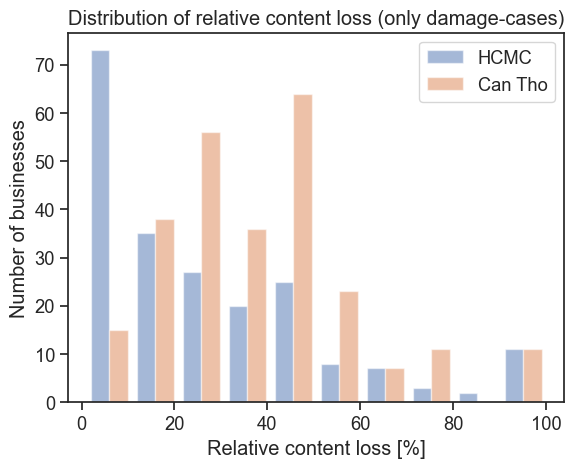

In [87]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_d["target_businessreduction"], bins, alpha=0.7, label="HCMC")
#plt.hist(df_cantho["target_businessreduction"], bins, alpha=0.7, label="Can Tho")


# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style(style="ticks")#"whitegrid", {"axes.grid" : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_d[target_degree], 
        df_cantho_d[target_degree]
    ], 
    #color=["r","b"], 
    alpha=0.5,  
    label=["HCMC", "Can Tho"],
    bins=10, #np.linspace(0, 101, 10)
)  ## TODO make bins in decimal steps, probably no ibs or prds between 70-80 -> thats why bins are not in dcimal steps

# plt.xticks(np.arange(0, 100, 10)),
plt.xlabel("Relative content loss [%]")
plt.ylabel("Number of businesses")
plt.legend(loc="upper right")
plt.title("Distribution of relative content loss (only damage-cases)")# (source: survey datasets)
plt.show()

#     bins=10 #np.linspace(0, 101, 10)
# )
# plt.xticks(np.arange(0, 100, 10)),

#  df_hcmc_pred_cd # rel rbred


### predict chance of loss - CanTho

In [88]:
## coef. of variation

#def calc_coef_of_vairation(x):
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
#    return cv

#calculate CV for each column in data frame
print(df_hcmc_incl_zero.apply(cv).sort_values())
# calc_coef_of_vairation


contaminations              39.461145
resilience                  40.648052
flow velocity               41.298777
emergency measures          63.819604
no. employees               65.281579
flood experience            65.505180
building age                71.736139
water depth inside          75.936968
non-structural measures     82.711816
mthly. income               85.338411
building area              100.484685
mthly. sales               120.059370
structural measures        123.478954
rbred                      136.480946
inundation duration        257.409318
dtype: float64


In [133]:
## predict chance of loss for CanTho
print("predicting chance of loss for CanTho")
y_cantho_c_pred_proba = clf.predict_proba(df_cantho_c_X)  # probabilitiies and predicted class

y_cantho_c_pred = np.argmax(y_cantho_c_pred_proba, axis=1)
y_cantho_c_proba = np.take_along_axis(
    y_cantho_c_pred_proba, 
    np.expand_dims(y_cantho_c_pred, axis=1), 
    axis=1
)
## store results in df
df_cantho_c[pred_target_chance] = y_cantho_c_proba
df_cantho_c[pred_target_chance + "_binary"] = y_cantho_c_pred.astype(float)

# y_cantho_proba = pd.DataFrame(y_cantho_c_proba)#.flatten()
# print(y_cantho_c_proba, y_cantho_c_pred)

##  update probability column in respect to y_pred, 
## currently zero-loss cases have also probability between 0.5 - 1.0 % --> should be 0.0 - 0.49 %: if ypred == 0 --> then proba should be 1.0 -> 0.0 ; 0.98 -> 0.02  [old proba -> new proba]
df_cantho_c = eu.reverse_probability_scores(df_cantho_c, pred_target_chance, (pred_target_chance+"_binary", 0.0))
df_cantho_c

print(f"Actual zero-loss: {len(np.where(df_cantho_c[target_chance] == 0)[0])}, \nActual damage: {df_cantho_c.loc[df_cantho_c[target_chance] == 1.0, : ].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_cantho_c[pred_target_chance + '_binary'] == 0)[0])}, \nPredict as damage: {len(np.where(df_cantho_c[pred_target_chance +'_binary'] == 1)[0])} ")




predicting chance of loss for CanTho
Actual zero-loss: 6, 
Actual damage: 261 

Predict as zero-loss: 37, 
Predict as damage: 230 


#### Plot predicted probability distrbution of chance of rbred

In [134]:
df_cantho_c[pred_target_chance].value_counts()

pred_chance of rbred
1.000    212
0.000     28
0.999      6
0.997      3
0.002      2
0.024      1
0.975      1
0.009      1
0.989      1
0.998      1
0.681      1
0.991      1
0.980      1
0.452      1
0.027      1
0.981      1
0.093      1
0.014      1
0.930      1
0.996      1
0.011      1
Name: count, dtype: int64

(array([ 35.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1., 228.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

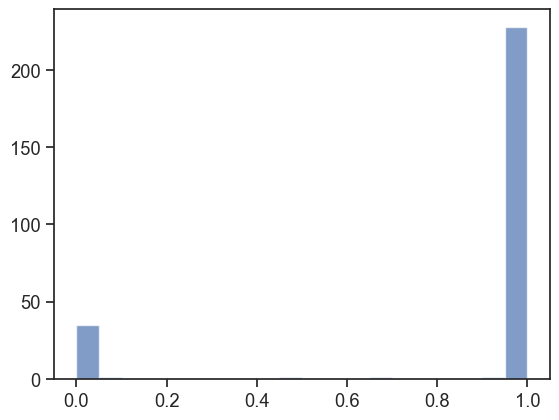

In [135]:
# df_hcmc_pred_cd
# df_hcmc_c.describe()

plt.hist(df_cantho_c[pred_target_chance][:], bins=20, alpha=0.7, label="probabilstic estimates of chance of loss")


In [136]:

## add chance of loss as column to results df
# df_cantho_c[pred_target_chance]= 0.0 ## NOTE keep as 0.0 to join with floats of y_pred, otherwise multiplcation with degree of rbred does not work
# df_cantho_c[f"{pred_target_chance}_binary"]= pred_chance of rbred_binar 
# df_cantho_c[pred_target_chance][:] =  df_cantho_c[pred_target_chance][:]  # pred. probas of chance,  join by neglecting different indices
df_cantho_c[f"{pred_target_chance}_binary"][:] =  df_cantho_c[f"{pred_target_chance}_binary"][:]  # pred. single values [0,1] of chance,  join by neglecting different indices
#df_hcmc_pred_cd[f"predicted chance of closs"]
df_cantho_c.describe()#[f"chance_pred_proba"]

,chance of rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales,pred_chance of rbred,pred_chance of rbred_binary
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.977528,4.219101,26.284644,0.715356,0.361049,42.719101,28.797753,96.861798,262.485019,0.300458,1.636704,0.296816,0.233458,2.767790,486.732210,0.861948,0.861423
std,0.148491,3.172919,15.617655,0.476386,0.110619,33.404782,14.539172,177.059603,273.050790,0.191680,1.194852,0.252169,0.206444,1.626384,1746.430001,0.341196,0.346153
min,0.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,12.800000,0.000000,0.000000
25%,1.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.500000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,85.600000,1.000000,1.000000
50%,1.000000,3.000000,20.000000,1.000000,0.400000,36.000000,26.000000,65.000000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,171.000000,1.000000,1.000000
75%,1.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,384.700000,1.000000,1.000000
max,1.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,25650.200000,1.000000,1.000000


Actual zero-loss: 6 
Actual damage: 186 

Predict as zero-loss: 37 
Predict as damage: 231 


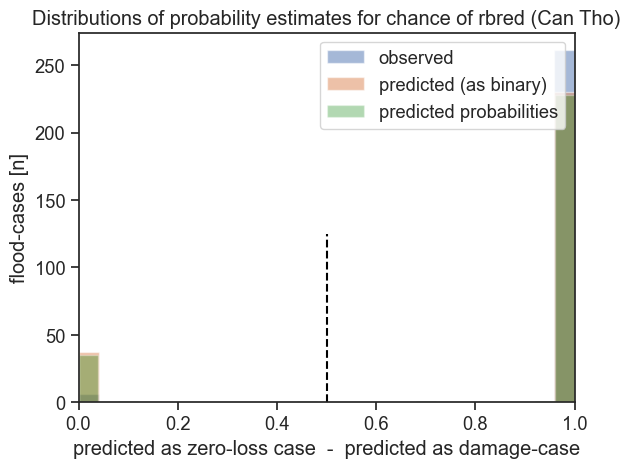

In [137]:

print(f"Actual zero-loss: {len(np.where( df_cantho_c['chance of rbred'] == 0)[0])} \nActual damage: {df_hcmc_c_true[df_hcmc_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_cantho_c[f'{pred_target_chance}_binary'] == 0)[0])} \nPredict as damage: {len(np.where(df_hcmc_c_pred == 1)[0])} ")


bins = np.linspace(0, 1, 25)
plt.hist( df_cantho_c["chance of rbred"], bins, alpha=0.5, label="observed")
plt.hist(df_cantho_c[f"{pred_target_chance}_binary"], bins, alpha=0.5, label="predicted (as binary)")
plt.hist(df_cantho_c[pred_target_chance], 25, alpha=0.3, label="predicted probabilities", color="green")
plt.legend(loc="upper right")
plt.title("Distributions of probability estimates for chance of rbred (Can Tho)")
plt.xlim(0,1)
plt.ylabel("flood-cases [n]")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")

plt.xlabel("predicted as zero-loss case  -  predicted as damage-case")
plt.show()


### predict degree of loss - CanTho

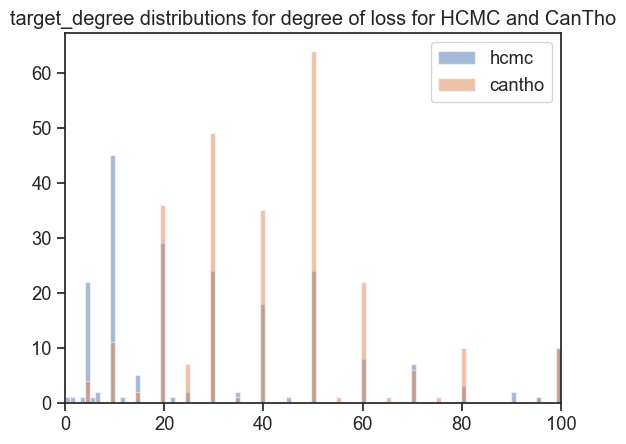

In [138]:
bins = np.linspace(0, 100, 100)

plt.hist(df_hcmc_d[target_degree], bins, alpha=0.5, label="hcmc")
plt.hist(df_cantho_d[target_degree], bins, alpha=0.5, label="cantho")
plt.legend(loc="upper right")
plt.title("target_degree distributions for degree of loss for HCMC and CanTho")
plt.xlim(0,100)
plt.show()


In [139]:
condition = condition #[1, 2, 3, 4 ]

df_cantho_d = df_cantho_d[df_hcmc_d.columns] # give cantho DF same column order as for HCMC ds, DF inlcudes only predicted damage cases

values = df_cantho_d.iloc[:,condition].to_numpy() # data for conditionalization
# values = df_cantho_bn[df_hcmc_d.columns].to_numpy() # data for conditionalization, only X, same variables as for BN contructed on HCMC

bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}


# BN build rank correlations from all damage-cases in HCMC dataset
R = bn_rankcorr(parent_cell,        # structure of the BN
    df_hcmc_d,   # matrix of df_hcmc
    var_names = names,  # names of variables
    is_data = True,        # matrix data contains actual data
    plot = False) 

## make inference for BN transfered to Can Tho, predict degree of loss for Can THo 
F = inference(condition,        # nodes that will be conditionalized
        values,           # information used to conditionalize the nodes of the NPBN
        R,                # the rank correlation matrix from BN constructed for damage-cases in HCMC 
        df_cantho_d,     # unseen ds from CanTHo only with damage cases, same predictors as used to train the BN for HCMC
        SampleSize=1000, Interp='next',
        Output="mean")    # type of output data
              #Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target_degree and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_d.loc[:,target_degree].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

## evaluate against test_nth_fold
bn_scores["MAE"].append(MAE)
bn_scores["MBE"].append(MBE)
bn_scores["RMSE"].append(RMSE)
bn_scores["SMAPE"].append(SMAPE)


print("Prediction performance for the degree of loss (Can Tho):" )  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

eu.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    261.000000
mean      37.865642
std        5.008682
min       23.756100
25%       34.784600
50%       37.970000
75%       40.854700
max       53.186000
dtype: float64
Prediction performance for the degree of loss (Can Tho):
MAE, MBE, RMSE, SMAPE: 16.34110191570881 -4.2416375478927195 21.59777384099443 20.61178094553092


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,261,40.0,42.107280,"[5, 100]",436.50,20.85,49.617725
predicted,261,37.0,37.371648,"[23, 53]",25.36,5.03,13.474448


In [140]:
pred_d_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residuals": pd.Series(y_pred) - pd.Series(y_true),
            },
            index=pd.Series(y_true).index,
        )
print(pred_d_cantho.describe())

# for c in pred_d_cantho.columns:
#     ci = eu.calc_confidence_interval(pred_d_cantho[c], 0.95)


           y_true      y_pred   residuals
count  261.000000  261.000000  261.000000
mean    42.107280   37.865642   -4.241638
std     20.892674    5.008682   21.217852
min      5.000000   23.756100  -74.812800
25%     30.000000   34.784600  -14.915500
50%     40.000000   37.970000   -2.030000
75%     50.000000   40.854700   10.263500
max    100.000000   53.186000   39.235300


In [96]:
# bins = np.linspace(0, 100, 100)

# plt.hist((pd.Series(pred_d_cantho.y_true.astype(int))), bins, alpha=0.5, label="empirical")
# plt.hist((pd.Series(pred_d_cantho.y_pred.astype(int))), bins, alpha=0.5, label="predicted")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for CanTho (empirical and predicted)")
# plt.show()


Condtionalize with missing predictor for non-structural measures [node 5], make inference of non-structural measures and target variable, condtionalize on the  remaining predictors

In [ ]:
# condition = [1, 2, 3, 4] #condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_d.iloc[:, [1, 2, 3, 4]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([1, 2, 3, 4],        # nodes that will be conditionalized - sparse model
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d, #df_cantho_bn.drop("water depth inside", axis=1),        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data
              #Output="median")    # type of output data

## inference of node for water depth and node for target
F_nonstruct = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_d.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, pd.Series(y_pred))

In [ ]:
residuals_cantho_sparse = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho_sparse.reset_index(drop=True, inplace=True)
residuals_cantho_sparse["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho_sparse["y_true"] >= 1)[0]
residuals_cantho_sparse.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho_sparse.describe()


print("Degree of rbred, cantho, sparse BN")
print(residuals_cantho_sparse.describe())



Degree of rcloss, cantho, sparse BN
           y_true      y_pred    residual  binary_true_dummy
count  132.000000  132.000000  132.000000         132.000000
mean    19.569181    0.321973  -19.247208           0.946970
std     21.490749    0.044879   21.488027           0.224948
min      0.149707    0.217400  -92.600717           0.000000
25%      3.736233    0.291950  -27.582127           1.000000
50%     10.631700    0.322425  -10.284275           1.000000
75%     27.888134    0.351175   -3.419754           1.000000
max     92.950717    0.433300    0.226243           1.000000


### CDFs of predictions of degree of rbred
Cumulative error of predictions for HCMC and Can THo

In [ ]:
residuals_hcmc

,y_true,y_pred,residual
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
312,0.0,0.0,0.0
313,0.0,0.0,0.0
314,0.0,0.0,0.0
315,0.0,0.0,0.0


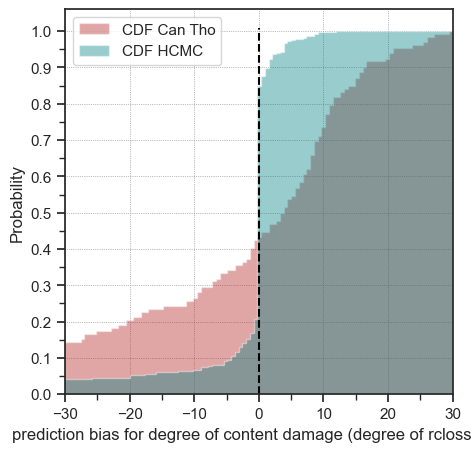

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [residuals_hcmc["residual"], pred_d_cantho["residuals"]],#, residuals_cantho_sparse["residual"]],  # pred HCMC+CanTHo rbred
    #[residuals_hcmc["residual"], pred_d_cantho["residuals"], residuals_cantho_sparse["residual"]],  # pred HCMC+CanTHo rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
   histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    # color=("teal","firebrick", "indianred"), 
    label=( "CDF HCMC", "CDF Can Tho",  "CDF Can Tho - sparse"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


# ## plt.xticks(np.arange(-80, 50, 10))
# plt.xlim(-100, 40)
# plt.xticks(np.arange(-100, 41, 20), minor=False)
# plt.xticks(np.arange(-100, 41, 10), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-30, 30, facecolor='grey', alpha=0.3)


## zoomed in
plt.xlim(-30, 30)
plt.xticks(np.arange(-30, 31, 10))
plt.xticks(np.arange(-30, 31, 5), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for degree of content damage (degree of rbred) [%]")
plt.ylabel("Probability")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")

# plt.title("Cumulative distribution functions (CDFs) of prediction bias, normalized")
# plt.savefig(OUTPATH_FIGURES + f"cdf_{pred_target_degree}.png", dpi=300, bbox_inches="tight")

plt.savefig(OUTPATH_BN + f"cdf_zoomed_{pred_target_degree}.png", dpi=300, bbox_inches="tight")




### Uncertainties in degree of rbred predictions

In [ ]:
condition = condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_d.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_d.iloc[:,0].to_numpy()


### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)


# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_p = pd.DataFrame()
df_uncertainties_c_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_p["observed"] = df_cantho_d["degree of rbred"]
df_uncertainties_c_p["city"] = "Can Tho"


In [ ]:
## uncertainties for sparse BN  - make inference on mthly [node:2]. sales and target

values = df_cantho_d.iloc[:,[2, 3, 4, 5]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([2, 3, 4, 5],        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


## inference of node for water depth and node for target
F_water = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_d.iloc[:,0].to_numpy()


dict = {}
for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_sparse_p = pd.DataFrame()
df_uncertainties_c_sparse_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_sparse_p["observed"] = df_cantho_d["degree of rbred"].reset_index(drop=True)
df_uncertainties_c_sparse_p["city"] = "Can Tho - sparse"
df_uncertainties_c_sparse_p

Inference - Uncertainty distribution:  count                                                   132
unique                                                  132
top       [20.0, 35.0, 3.0, 10.0, 10.0, 20.0, 10.0, 15.0...
freq                                                      1
dtype: object


,avg_modelled,observed,city
0,23.8269,0.662986,Can Tho - sparse
1,22.9212,0.149707,Can Tho - sparse
2,22.9917,4.341588,Can Tho - sparse
3,20.9294,9.294347,Can Tho - sparse
4,22.5614,3.281143,Can Tho - sparse
...,...,...,...
127,26.3752,3.094005,Can Tho - sparse
128,26.3700,10.623822,Can Tho - sparse
129,26.6423,53.117690,Can Tho - sparse
130,26.6522,6.200487,Can Tho - sparse


In [ ]:
## join uncertainites from BNs for hcmc, cantho, and cantho-sparse 

df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p], axis=0)
# df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p, df_uncertainties_c_sparse_p], axis=0)
df_uncertainties_hc_sparse_p
# df_uncertainties_hc_p = pd.melt(df_uncertainties_hc_p, id_vars=['city'], var_name=['city'])
print(df_uncertainties_hc_sparse_p)


     avg_modelled   observed     city
0       11.870968   0.920782     HCMC
1        1.880111   0.805886     HCMC
2        2.932630   0.805886     HCMC
3       34.649534  73.531408     HCMC
4       10.880495   0.799444     HCMC
..            ...        ...      ...
127     12.707225   1.336630  Can Tho
128      5.691546   8.059385  Can Tho
129     21.834180   9.294347  Can Tho
130     29.474669        NaN  Can Tho
131     14.313939   0.668315  Can Tho

[258 rows x 3 columns]


In [ ]:
df_uncertainties_hc_sparse_p.describe()

,avg_modelled,observed
count,258.000000,196.000000
mean,15.234882,15.089906
std,12.806466,21.019056
min,1.188771,0.149707
25%,7.752552,1.699115
50%,12.326271,5.637041
75%,19.844606,18.220591
max,91.772324,92.950717


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


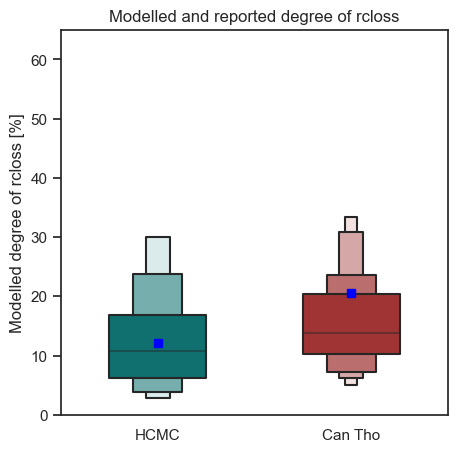

In [ ]:
group = "city"
column = "avg_modelled"
scatterpoints="observed"


grouped = df_uncertainties_hc_sparse_p.groupby(group)
categories = np.unique(df_uncertainties_hc_sparse_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))


names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())

# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(5, 5))
fig.canvas.draw()


## average predicted means
p = sns.boxenplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["avg_modelled"],
    width=.5,
    showfliers=False,
    # showmeans=True,
    palette=["teal", "firebrick"],
    # palette=["teal", "firebrick", "lightcoral"],
    line_kws={"linewidth":1.5},# color":"cde"
    flier_kws={"facecolor":.7, "linewidth":.5},
)

# observed mean
sns.boxplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["observed"],
    # labels="HCMC",
    showfliers=False,
    showmeans=True,
    medianprops={"color": "r", "linewidth": 0, "alpha":0.0},
    boxprops={"facecolor":"steelblue", "alpha":0.0},
    whiskerprops={"color":"k", "alpha":0.},
    capprops={"color":"k", "alpha":0},
    # medianprops={"color": "blue", "markerfacecolor":"blue", "markeredgecolor":"blue"},
    meanprops={"marker":"s", "markerfacecolor":"blue", "markeredgecolor":"blue"}
)

p.tick_params(bottom=False)  # remove x ticks
# ax.get_legend().set_visible(False)
plt.legend().set_visible(False)  # surpress legend

plt.ylim(0, 65)
plt.ylabel(f"Modelled {target_degree} [%]")
plt.xlabel(f"")
plt.title("Modelled and reported degree of rbred")

plt.savefig(OUTPATH_BN + f"uncertainties_{target_degree}.png", dpi=300, bbox_inches="tight")


In [ ]:
df_hcmc_d.describe()

,degree of rcloss,water depth inside,mthly. sales,building age,structural measures,non-structural measures
count,126.000000,126.000000,126.000000,122.000000,126.000000,126.000000
mean,12.064998,38.031746,325.890476,19.745902,0.202381,0.349206
std,19.907199,28.148730,276.457742,12.656662,0.276973,0.272175
min,0.179416,2.000000,92.100000,0.000000,0.000000,0.000000
25%,1.432871,20.000000,92.100000,12.000000,0.000000,0.250000
50%,3.807401,30.000000,276.200000,18.000000,0.000000,0.250000
75%,10.586663,50.000000,276.200000,24.000000,0.500000,0.500000
max,91.672324,150.000000,1473.000000,62.000000,1.000000,1.000000


In [ ]:
import folium
map = folium.Map(location=[106.6637,10.6878], default_zoom_start=15)


### relative content loss estimates (chance * degree of loss)

In [142]:
assert all(df_cantho_d[target_degree].index == df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rbred]> 0.0, target_rbred].index) == True, 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '
# assert len(df_cantho_c.loc[df_cantho_c[target_degree]> 0.0, target_degree].index) == len(df_cantho_d[target_degree].index) , 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

In [144]:
## index of damage cases
idx_damage = np.where(df_cantho_c_y == 1)[0]

## new col incl osbervation and prediction of degree of loss, thus all non-damage cases are 0 
df_cantho_pred_cd = df_cantho_incl_zero
### obs
df_cantho_pred_cd[target_degree] = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rbred]> 0.0, target_rbred]
## preds
df_cantho_pred_cd[pred_target_degree] = 0.0 
df_cantho_pred_cd.loc[idx_damage, pred_target_degree] = y_pred  ## add predicted degree of loss to df
df_cantho_pred_cd.loc[idx_damage, "degree_pred"] = y_pred  # BN results for degree needed for abs. degree of loss

## new col incl osbervation and prediction of chance of loss,
df_cantho_pred_cd[target_chance] = df_cantho_c[target_chance]
df_cantho_pred_cd[pred_target_chance] =  df_cantho_c[pred_target_chance]
df_cantho_pred_cd[pred_target_chance+"_binary"] = df_cantho_c[pred_target_chance+"_binary"]
df_cantho_pred_cd.describe()

,rbred,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,shp_sector,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,shp_content_value_euro,mthly. sales,degree of rbred,pred_degree of rbred,degree_pred,chance of rbred,pred_chance of rbred,pred_chance of rbred_binary
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,261.000000,267.000000,261.000000,267.000000,267.000000,267.000000
mean,41.161049,4.219101,26.284644,0.715356,0.361049,42.719101,28.797753,96.861798,2.576779,262.485019,0.300458,1.636704,0.296816,0.233458,2.767790,1188.389856,486.732210,42.107280,37.014729,37.865642,0.977528,0.861948,0.861423
std,21.581292,3.172919,15.617655,0.476386,0.110619,33.404782,14.539172,177.059603,1.632812,273.050790,0.191680,1.194852,0.252169,0.206444,1.626384,2870.333175,1746.430001,20.892674,7.492380,5.008682,0.148491,0.341196,0.346153
min,0.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,1.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,26.716667,12.800000,5.000000,0.000000,23.756100,0.000000,0.000000,0.000000
25%,30.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.500000,1.000000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,160.325000,85.600000,30.000000,34.474050,34.784600,1.000000,1.000000,1.000000
50%,40.000000,3.000000,20.000000,1.000000,0.400000,36.000000,26.000000,65.000000,2.000000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,374.075000,171.000000,40.000000,37.939600,37.970000,1.000000,1.000000,1.000000
75%,50.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,4.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,801.562500,384.700000,50.000000,40.732450,40.854700,1.000000,1.000000,1.000000
max,100.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,6.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,37406.450000,25650.200000,100.000000,53.186000,53.186000,1.000000,1.000000,1.000000


In [147]:
df_cantho_pred_cd[[pred_target_degree, pred_target_chance]].describe()

,pred_degree of rbred,pred_chance of rbred
count,267.000000,267.000000
mean,37.014729,0.995777
std,7.492380,0.034592
min,0.000000,0.547999
25%,34.474050,1.000000
50%,37.939600,1.000000
75%,40.732450,1.000000
max,53.186000,1.000000


In [148]:
## index of damage cases
idx_damage = np.where( df_cantho_c[target_chance] == 1)[0]

## new col incl osbervation and prediction of degree of loss, thus all non-damage cases are 0 
df_cantho_pred_cd = df_cantho_incl_zero
### obs
df_cantho_pred_cd[target_degree] = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rbred]> 0.0, target_rbred]
## preds
pred_target_degree = f"pred_{target_degree}"
df_cantho_pred_cd[pred_target_degree] = 0.0 
df_cantho_pred_cd.loc[idx_damage, pred_target_degree] = y_pred  ## add predicted degree of loss to df
df_cantho_pred_cd.loc[idx_damage, "degree_pred"] = y_pred  # BN results for degree needed for abs. degree of loss


# assert df_cantho_d[target_degree].index.all() == df_cantho_pred_cd.loc[df_cantho_pred_cd[target_degree]>0.0, target_degree].index.all(), 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '
# print(df_cantho_pred_cd[[target_degree, pred_target_degree]].describe())
# print(df_cantho_incl_zero[target_degree].describe())



## pred_d_cantho  # degree of damages
## y_cantho_proba # chance that instance is a damage-case

## get estimation of relative content loss
df_cantho_pred_cd[pred_target_rbred] = None
df_cantho_pred_cd[pred_target_rbred] = df_cantho_pred_cd[pred_target_degree] * df_cantho_pred_cd[pred_target_chance] # y_cantho_c_proba.squeeze()
df_cantho_pred_cd[pred_target_rbred].describe()


## add binary observation and prediction of chance of loss
df_cantho_pred_cd["observed chance of closs"] = 0.0
df_cantho_pred_cd.loc[idx_damage, "observed chance of closs"] = 1
df_cantho_pred_cd[f"{pred_target_chance}_binary"] = y_cantho_c_pred
## add porabilities of prediction of chance of rbred
df_cantho_pred_cd[pred_target_chance] = y_cantho_c_proba

df_cantho_pred_cd[[target_rbred, pred_target_rbred, target_degree,"degree_pred", "observed chance of closs", pred_target_chance, f"{pred_target_chance}_binary"]].describe()

## NOTE that chance of loss was nearly always predicted with 0.99% or 100% probability of being zero

,rbred,pred_rbred,degree of rbred,degree_pred,observed chance of closs,pred_chance of rbred,pred_chance of rbred_binary
count,267.000000,267.000000,261.000000,261.000000,267.000000,267.000000,267.000000
mean,41.161049,36.838624,42.107280,37.865642,0.977528,0.995777,0.861423
std,21.581292,7.513684,20.892674,5.008682,0.148491,0.034592,0.346153
min,0.000000,0.000000,5.000000,23.756100,0.000000,0.547999,0.000000
25%,30.000000,34.373950,30.000000,34.784600,1.000000,1.000000,1.000000
50%,40.000000,37.744500,40.000000,37.970000,1.000000,1.000000,1.000000
75%,50.000000,40.719800,50.000000,40.854700,1.000000,1.000000,1.000000
max,100.000000,53.186000,100.000000,53.186000,1.000000,1.000000,1.000000


## Evaluation of rbred estimations -Can THo

In [149]:
## get ratio of damage cases vs total reported bred

c = df_cantho_pred_cd[target_degree]
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


261
97.75280898876404 %


42.10727969348659

In [150]:
## TODO make less but more consistent var names ,eg replace rbred_ture with respective column from df_cantho_pred_cd

rbred_true = df_cantho_pred_cd[target_rbred]
rbred_pred = df_cantho_pred_cd[pred_target_rbred]

# evaluation metrics
MAE = eu.mean_absolute_error(rbred_true, rbred_pred)
MBE = eu.mean_bias_error(rbred_true, rbred_pred)
RMSE = eu.root_mean_squared_error(rbred_true, rbred_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(rbred_true, rbred_pred)


print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  


#print("\n", 
eu.empirical_vs_predicted(rbred_true, rbred_pred)


MAE,: 15.9032016472985
MAE, MBE, RMSE, SMAPE: 15.9032016472985 -4.32242479862151 21.31846213753742 20.04809084550234


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,267,40.0,41.161049,"[0, 100]",465.75,21.54,52.431346
predicted,267,37.0,36.344569,"[0, 53]",55.94,7.47,20.579058


In [151]:
print("rbred, cantho")
print(df_cantho_pred_cd[[target_rbred, pred_target_rbred]].describe())

for c in df_cantho_pred_cd[[target_rbred, pred_target_rbred]].columns:
    ci = eu.calc_confidence_interval(df_cantho_pred_cd[c], 0.95)


rbred, cantho
            rbred  pred_rbred
count  267.000000  267.000000
mean    41.161049   36.838624
std     21.581292    7.513684
min      0.000000    0.000000
25%     30.000000   34.373950
50%     40.000000   37.744500
75%     50.000000   40.719800
max    100.000000   53.186000
confidence interval: (38.56058740762597, 43.76150997065118) 
cases within interval: 35
confidence interval: (35.93325430927271, 37.74399347176143) 
cases within interval: 41


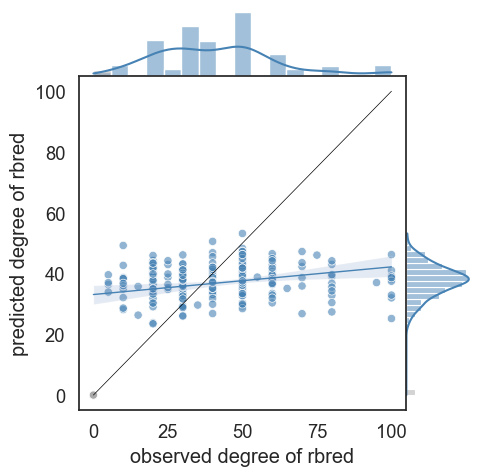

In [152]:
f.plot_observed_predicted(
    df_cantho_pred_cd[target_rbred], df_cantho_pred_cd[pred_target_rbred],  
    hue = df_cantho_pred_cd["observed chance of closs"],
    #hue=df_cantho_pred_cd[f"{pred_target_chance}_binary"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}", #target=target_plot,
    legend=False, #True
    outfile=OUTPATH_BN + f"./scatter_obs_pred_{target_plot}_cantho.png"
)       

## NOTE the single grey dot means: that nearly all chance of loss cases were predicted as zero-losses

In [ ]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_d[target_degree], bins, alpha=0.5, label="hcmc rbred")
# plt.hist(df_cantho[target_degree], bins, alpha=0.5, label="cantho rbred")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for both cities (empirical)")
# plt.show()


### Main validation results

Compare with Chinh 2016 for ChanTho closs:
aveg. content loss:


#### Plot residuals

In [ ]:
df_cantho_pred_cd[["rbred", "pred_rbred", "pred_degree of rbred", "degree_pred", "chance of rbred", "pred_chance of rbred_binary", "pred_chance of rbred"]].describe()

,rbred,pred_rbred,pred_degree of rbred,degree_pred,chance of rbred,pred_chance of rbred_binary,pred_chance of rbred
count,267.000000,267.0,267.000000,261.000000,267.000000,267.000000,267.000000
mean,41.161049,0.0,37.082575,37.935048,0.977528,0.861423,0.995777
std,21.581292,0.0,7.542814,5.073855,0.148491,0.346153,0.034592
min,0.000000,0.0,0.000000,23.786400,0.000000,0.000000,0.547999
25%,30.000000,0.0,34.427150,34.808700,1.000000,1.000000,1.000000
50%,40.000000,0.0,38.155000,38.219900,1.000000,1.000000,1.000000
75%,50.000000,0.0,40.932550,40.954900,1.000000,1.000000,1.000000
max,100.000000,0.0,53.541000,53.541000,1.000000,1.000000,1.000000


Text(0, 0.5, 'residuals (prediction - observation)')

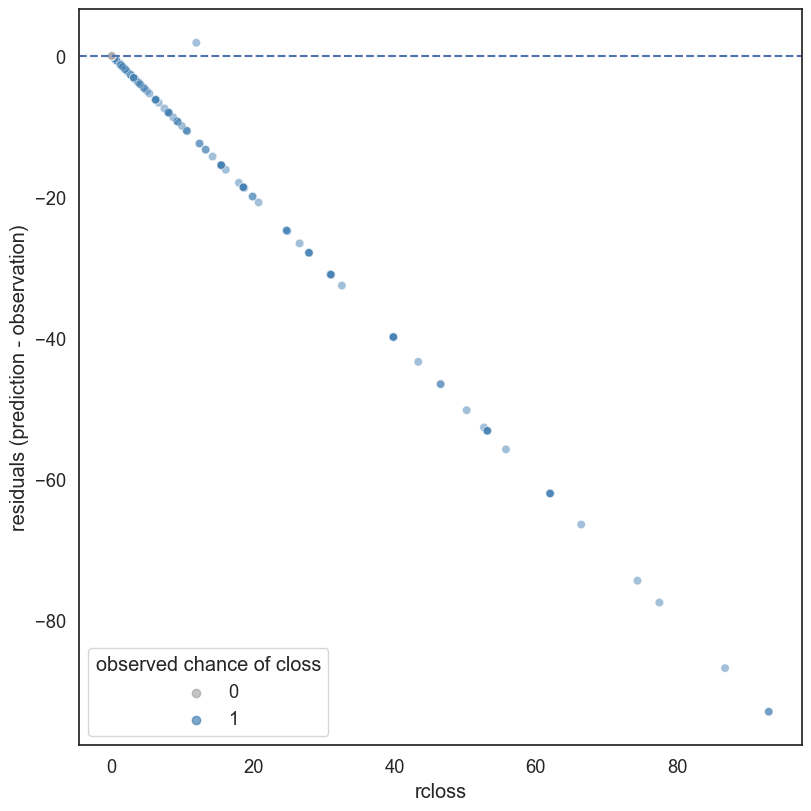

In [ ]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0.0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1.0: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = df_cantho_pred_cd[target_rbred], 
    y = df_cantho_pred_cd[pred_target_rbred] - df_cantho_pred_cd[target_rbred], 
    hue = df_cantho_pred_cd["observed chance of closs"].astype(int),
    # hue = df_cantho_pred_cd[pred_target_chance+"_binary"].astype(int),  # NOTE all chance of loss cases were predicted as zero loss
    #color = "steelblue",
    alpha = 0.5,
    #hue=df_hcmc_adegree["abs_degree_true_dummy"]
    palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")



#### Plot predicted probabilities of transferred ML-estimator

In [ ]:
df_hcmc_c_pred = df_cantho_pred_cd[f"{pred_target_chance}_binary"]
df_hcmc_c_proba = df_cantho_pred_cd[pred_target_chance]
df_hcmc_c_true = df_cantho_pred_cd["chance of rbred"]

print(f"Actual zero-loss: {len(np.where(df_hcmc_c_true == 0)[0])} \nActual damage: {df_hcmc_c_true[df_hcmc_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_hcmc_c_pred == 0)[0])} \nPredict as damage: {len(np.where(df_hcmc_c_pred == 1)[0])} ")


bins = np.linspace(0, 1, 25)
plt.hist(df_hcmc_c_true, bins, alpha=0.5, label="observed")
plt.hist(df_hcmc_c_pred, bins, alpha=0.5, label="predicted (as binary)")
plt.hist( df_hcmc_c_proba, 25, alpha=0.3, label="predicted probabilities", color="green")
plt.legend(loc="upper right")
plt.title("Distributions of probability estimates for chance of rbred (HCMC)")
plt.xlim(0,1)
plt.ylabel("flood-cases [n]")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")

plt.xlabel("predicted as zero-loss case  -  predicted as damage-case")
plt.show()


### Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

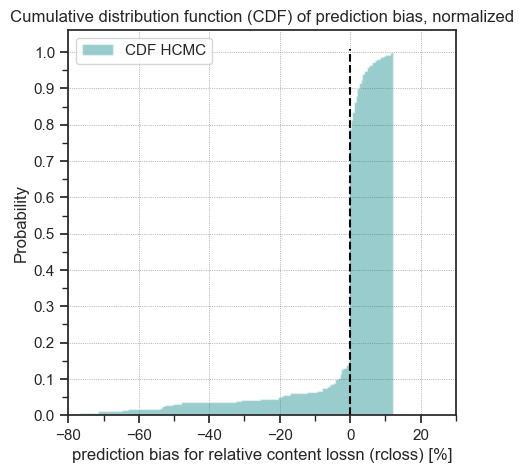

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    residuals_hcmc["residual"],
    # [residuals_hcmc["residual"], df_cantho_pred_cd[pred_target_rbred] - df_cantho_pred_cd[target_rbred]], # pred HCMC+CanTHo rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    # color=("teal","firebrick"), 
    color=("teal"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


## plt.xticks(np.arange(-80, 50, 10))
plt.xlim(-80, 30)
plt.xticks(np.arange(-80, 31, 10), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-20, 20, facecolor='grey', alpha=0.3)

# ## zoomed in
# plt.xlim(-20, 20)
# plt.xticks(np.arange(-20, 21, 10))
# plt.xticks(np.arange(-20, 21, 5), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for relative content lossn (rbred) [%]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction bias, normalized")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


plt.savefig(OUTPATH_BN + "cdf_rbred.png", dpi=300, bbox_inches="tight")
# plt.savefig(OUTPATH_BN + "cdf_zoomed_closs.png", dpi=300, bbox_inches="tight")




## Absolute content loss

In [ ]:
# assert df_cantho_d[target_degree].all() == df_cantho_pred_cd[target_degree].all(), "fix upper code were y_true is shuffled - residual ddf should have the same order as when it was loaded"

In [ ]:
df_cantho_acloss = df_cantho_pred_cd.copy()

## use true reported abs closs from survey
df_cantho_acloss["acloss"] = df_cantho_acloss["closs"] # df_cantho_acloss[target_degree] *  df_cantho_acloss["shp_content_value_euro"] / 100

## NOTE use here vulnerability rbred (BN*chance)
df_cantho_acloss["pred_acloss"] = df_cantho_acloss[pred_target_rbred] *  df_cantho_acloss["shp_content_value_euro"] / 100 
print("pred_acloss has no zero-loss cases (min=", round(df_cantho_acloss["pred_acloss"].min(),2), ") and", df_cantho_acloss.shape[0],"damage cases")

## NOTE use here BN result (degree of loss)
# df_cantho_acloss["abs_degree_pred"] = df_cantho_acloss["degree_pred"] *  df_cantho_acloss["shp_content_value_euro"] / 100 
# df_cantho_acloss["abs_degree_pred"] = df_cantho_acloss["degree_pred"] *  df_cantho_acloss["shp_content_value_euro"] / 100 
# print("abs_degree_pred has no zero-loss cases (min=", round(df_cantho_acloss["abs_degree_pred"].min(),2), ") and", df_cantho_acloss.shape[0],"damage cases")

## keep only damage cases to calc abs. degree of loss
print("check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables")
assert df_cantho_acloss.acloss[df_cantho_acloss["acloss"] > 0.0].index.all() == df_cantho_acloss.pred_acloss[df_cantho_acloss["pred_acloss"] > 0.0].index.all(), "not same idx in obs and pred degree of loss"

##  NOTE use here BN result (degree of loss)
# df_cantho_adegree = pd.DataFrame(columns=["abs_degree_true", "abs_degree_pred"]).reset_index(drop=True)
# df_cantho_adegree["abs_degree_true"] = df_cantho_acloss["acloss_true"][df_cantho_acloss["acloss_true"] > 0.0]
# df_cantho_adegree["abs_degree_pred"] = df_cantho_acloss["abs_degree_pred"][df_cantho_acloss["acloss_true"] > 0.0]  # remove all np.nan in "abs_degree_pred" (these are the zero-loss cases) by using idx from obs. zero-loss

print("Can Tho : absolute degree of content loss (only damage cases)")
print(eu.empirical_vs_predicted(df_cantho_acloss["acloss"], df_cantho_acloss["pred_acloss"]))
# print(eu.empirical_vs_predicted(df_cantho_adegree["abs_degree_true"], df_cantho_adegree["abs_degree_pred"]))


## add dummy binary var for plotting
# df_cantho_adegree["abs_degree_true_dummy"] =  1.0   



## my results [n=283 businesses]  NOTE only damage-cases (degree of loss, used directly from BN output) 
## abs degree in HCMC   [n=114], mean (median): observed is 352.5€ (117.0) , predicted 575.1€ (352.0)
## abs degree in Cantho [n=138], mean (median): observed is 101.4€ (49.0) , predicted 201.3€ (61.5)  <-> Chinh16  135.9 € (27.6 €)

###########################################################################

## Can Tho : absolute degree of content loss (only damage cases)
#         nobs  median        mean    min max   variance      standard deviation     coef variation  
# empirical   138    49.0  101.413043   [2, 993]   20799.57           143.70           142.211065 
# predicted   138    61.5  205.884058   [2, 3438]  159394.69          397.79           193.916249  


## HCMC abs degree of loss
# #	       nobs	median	mean	    min max	   variance	standard deviation	coef variation
# empirical	114	117.0	352.517544	[7, 3618]	347977.77	587.30	        167.338171
# predicted	114	352.5	575.140351	[19, 6483]	812338.46	897.34	        156.709263

## Chinh 2016  [price level 2011]
## abs degree in Cantho, mean (median): observed 118 USD (24 USD )
#                    -->  final converted:      135.9 € (27.6 €) 	 in euro [2020]



pred_acloss has no zero-loss cases (min= 0.0 ) and 266 damage cases
check that osberved and predicted damage cases have the same index and can be therefore clipped by the index of one of both variables
Can Tho : absolute degree of content loss (only damage cases)
           nobs  median       mean   min max  variance  standard deviation   
empirical   266     0.0  51.172932  [0, 993]  13257.84              114.93  \
predicted   266     0.0   0.191729   [0, 51]      9.78                3.12   

           coef. of variation  
empirical          225.007042  
predicted         1630.950643  


In [ ]:
df_cantho_acloss

,rcloss,closs,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,emergency measures,mthly. income,non-structural measures,no. employees,structural measures,resilience,shp_content_value_euro,mthly. sales,degree of rcloss,pred_degree of rcloss,degree_pred,chance of rcloss,pred_chance of rcloss,pred_chance of rcloss_binary,pred_rcloss,observed chance of closs,acloss,pred_acloss
0,0.000000,0.0,3.0,40,1,0.4,76,16.0,60.0,0.444444,149.6,0.00,1,0.000000,5,80.1625,855.0,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0,0.0,0.0
1,0.662986,24.8,3.0,30,1,0.5,76,26.0,31.5,0.444444,320.6,0.25,3,0.333333,1,3740.6500,641.3,0.662986,21.399714,21.399714,1.0,1.0,0,0.0,1.0,24.8,0.0
2,0.000000,0.0,3.0,20,1,0.4,76,16.0,20.0,0.444444,320.6,0.50,1,0.333333,5,40.0750,641.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0,0.0,0.0
3,0.000000,0.0,4.0,40,1,0.3,76,16.0,49.0,0.222222,149.6,0.50,2,0.000000,4,801.5500,128.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0,0.0,0.0
4,0.149707,6.0,1.0,20,0,0.3,8,8.0,100.0,0.222222,320.6,0.75,1,0.333333,1,4007.8375,64.1,0.149707,12.636456,12.636456,1.0,1.0,0,0.0,1.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,6.200487,49.7,3.0,50,0,0.1,76,36.0,30.0,0.111111,149.6,0.00,1,0.000000,2,801.5500,171.0,6.200487,29.720701,29.720701,1.0,1.0,0,0.0,1.0,49.7,0.0
262,0.000000,0.0,5.0,60,0,0.1,8,26.0,140.0,0.555556,320.6,0.50,1,0.333333,2,1603.1250,299.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0,0.0,0.0
263,0.000000,0.0,2.0,20,1,0.3,8,16.0,184.0,0.444444,149.6,0.50,1,0.333333,3,374.0750,85.6,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0,0.0,0.0
264,1.546979,24.8,3.0,20,1,0.3,8,26.0,150.0,0.444444,320.6,0.50,4,0.666667,1,1603.1250,1710.0,1.546979,15.087171,15.087171,1.0,1.0,0,0.0,1.0,24.8,0.0


In [ ]:
df_cantho_acloss[["acloss",	"pred_acloss"]][:20]  
# NOTE to many zero losses: Due that nearly all chance of loss cases were predicted as zero-loss cases with either 0.99 % certainty (all damage-cases) or 100% certainty (all zero loss cases)

,acloss,pred_acloss
0,0.0,0.0
1,24.8,0.0
2,0.0,0.0
3,0.0,0.0
4,6.0,0.0
5,17.4,0.0
6,74.5,0.0
7,26.3,0.0
8,0.0,0.0
9,9.9,0.0


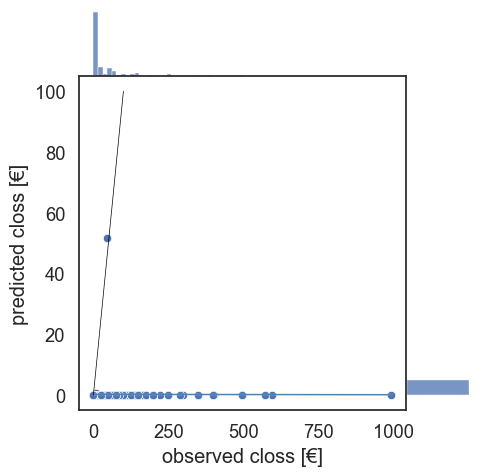

In [ ]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 

plot_observed_predicted_abs(
    y_true=df_cantho_acloss["acloss"], y_pred=df_cantho_acloss["pred_acloss"], 
    hue=None, #df_cantho_acloss["abs_degree_true_dummy"],
    # hue=df_cantho_pred_cd[f"{pred_target_chance}_binary"],
    xlabel=f"observed closs [€]", ylabel=f"predicted closs [€]", #target=target_plot,
    legend=False ,#True
    outfile= OUTPATH_BN + f"./scatter_obs_pred_abs_closs_{target_plot}_cantho.png"
)     
# plot_observed_predicted_abs(
#     y_true=df_cantho_adegree["abs_degree_true"], y_pred=df_cantho_adegree["abs_degree_pred"], 
#     hue=df_cantho_adegree["abs_degree_true_dummy"],
#     # hue=df_cantho_pred_cd[f"{pred_target_chance}_binary"],
#     xlabel=f"observed abs. degree of closs [€]", ylabel=f"predicted abs. degree of closs [€]",
#     legend=False ,#True
#     outfile= OUTPATH_BN + f"./scatter_obs_pred_abs_degree_{target_plot}_cantho.png"
# )     


In [ ]:
## get  reported losses in CHinh 2016 from USD [2011] to Euro [2020]

# # GDP deflator source : https://jp.tradingeconomics.com/united-states/gdp-deflator
gdp_price_index_2011 = 91.48  # 2011  #  chinh 2016 uses 2011 as reference year
gdp_price_index_2020 = 105.37 # price level 2020 based on GDP-deflation

# for r in range(len(vars_money.target_contentloss_VND)):
chinh16_results = pd.DataFrame({
    "mean_degree_closs_usd": [118], # price level 2011 in USD
    "median_degree_closs_usd": [24] ,# price level 2011 in USD
    "mean_degree_closs_euro": [None],
    "median_degree_closs_euro": [None],
})
for r in range(len(chinh16_results.mean_degree_closs_usd)):
    chinh16_results["mean_degree_closs_euro"][r] = round(chinh16_results["mean_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro
    chinh16_results["median_degree_closs_euro"][r] = round(chinh16_results["median_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro

chinh16_results

,mean_degree_closs_usd,median_degree_closs_usd,mean_degree_closs_euro,median_degree_closs_euro
0,118,24,135.9,27.6


NOtes to  abs loss Cnatho


In [ ]:


# # ### Plot prediction error from outer cv
# f.plot_results(
#     results=predicted_values, 
#     model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
#     model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
#     outfile=f"../model_results/models_evaluation/degree_of_loss/results_{target_degree}.png"
# )


In [ ]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_d[target_degree], bins, alpha=0.5, label="hcmc rbred")
# plt.hist(df_cantho[target_degree], bins, alpha=0.5, label="cantho rbred")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for both cities (empirical)")
# plt.show()


In [ ]:
## check bage ~ rbred 

# sns.scatterplot(x=df_hcmc_d["bage"], y=df_hcmc_incl_zero[target_degree])
tt = df_hcmc_pred_cd.loc[df_hcmc_pred_cd[target_degree]>0,:]

plot_observed_predicted_abs(
    #y_true=df_hcmc_d["bage"], y_pred=df_hcmc_d[target_degree], 
    y_true=tt["building age"], y_pred=tt[target_degree], 
    #hue=df_hcmc_pred_cd["bage"],
    hue=tt["predicted chance of closs"],
    xlabel="bage", ylabel=f"obs. rel. degree of closs",# target=target_plot,
    legend=False ,#True
    outfile= OUTPATH_BN + f"./scatter_test_bage_degree_hcmc.png"
)     

## --> all bui which were built before the boom (start of city growth in mid-late 80s) have much lower rel. losses than bui consturcted durign city boom late 80s-2010

KeyError: 'degree of rcloss'

## Abs. degree of contnet loss ~ Income 

compare degree of contnet loss in monetary terms with income levels, in the view to better compare the findings with the reults fro mChinh 2016 for SMEs in Can Tho

In [ ]:
df_hcmc_income = df_hcmc_incl_zero.loc[df_hcmc_incl_zero["closs"]>0.0, ["closs", "rbred", "mthly. income"]]
df_hcmc_income["rloss_income"] = df_hcmc_income["closs"] / df_hcmc_income["mthly. income"] * 100
df_hcmc_income.describe()


,closs,rcloss,mthly. income,rloss_income
count,126.000000,126.000000,118.000000,118.000000
mean,324.936508,12.064998,431.611017,87.911525
std,499.595655,19.907199,311.649514,130.374996
min,7.400000,0.179416,110.500000,1.232402
25%,39.300000,1.432871,294.600000,12.898846
50%,122.600000,3.807401,294.600000,41.064935
75%,373.000000,10.586663,552.400000,91.208418
max,2984.200000,91.672324,2393.700000,886.354379


In [ ]:
print("Number of buisnesses for with content loss exceds income :", df_hcmc_income[df_hcmc_income["rloss_income"]> 100].shape[0])
df_hcmc_income[df_hcmc_income["rloss_income"]> 100].tail(4)

Number of buisnesses for with content loss exceds income : 29


,closs,rcloss,mthly. income,rloss_income
282,559.5,12.154588,294.6,189.918534
286,123.9,3.364471,110.5,112.126697
292,1473.0,58.823529,552.4,266.654598
296,447.6,4.861835,294.6,151.934827


In [ ]:
# df_cantho_incl_zero_p = df_cantho_incl_zero.loc[df_cantho_incl_zero["mthly. income"] > 50, :]
df_cantho_income = df_cantho_incl_zero.loc[df_cantho_incl_zero["closs"]>0.0, ["closs", "rbred", "mthly. income"]]
df_cantho_income["rloss_income"] = df_cantho_income["closs"] / df_cantho_income["mthly. income"] * 100
df_cantho_income.describe()

# df_cantho_incl_zero_p = df_cantho_incl_zero.loc[df_cantho_incl_zero["mthly. income"] > 50, :]
# df_cantho_incl_zero.loc[df_cantho_incl_zero["closs"] > 0.0, ["closs", "rbred", "mthly. income"]].describe()
# # df_cantho_incl_zero_p.loc[df_cantho_incl_zero_p["closs"] > 0.0, ["closs", "mthly. income"]].describe()

,closs,rcloss,mthly. income,rloss_income
count,132.000000,132.000000,132.000000,132.000000
mean,103.681818,19.569181,266.599242,55.757941
std,146.304769,21.490749,292.537394,80.315332
min,2.500000,0.149707,10.700000,0.779788
25%,24.800000,3.736233,149.600000,11.426433
50%,49.700000,10.631700,149.600000,20.149719
75%,124.200000,27.888134,320.600000,61.977542
max,993.600000,92.950717,2137.500000,465.625000


In [ ]:
print("Number of buisnesses for with content loss exceds income :", df_cantho_income[df_cantho_income["rloss_income"]> 100].shape[0])
df_cantho_income[df_cantho_income["rloss_income"]> 100]

Number of buisnesses for with content loss exceds income : 19


,closs,rcloss,mthly. income,rloss_income
33,397.4,24.789084,149.6,265.641711
38,74.5,92.950717,64.1,116.224649
48,496.8,61.979914,320.6,154.959451
50,298.1,18.594932,149.6,199.264706
54,49.7,62.008734,32.0,155.312500
57,149.0,39.831585,32.0,465.625000
61,69.5,43.349446,32.0,217.187500
72,596.1,74.368411,149.6,398.462567
73,129.2,16.118770,64.1,201.560062
88,223.6,27.895952,149.6,149.465241


(-10000.0, 10000.0)

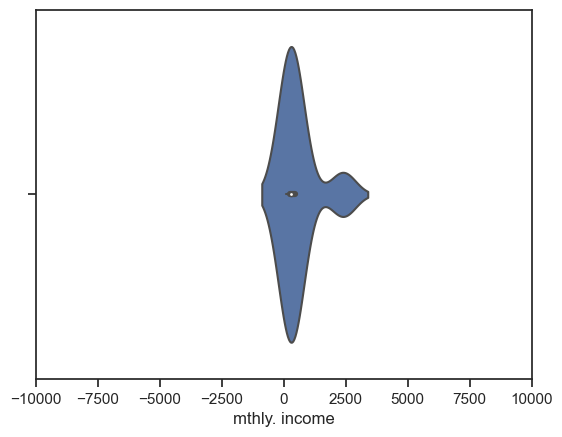

In [ ]:
import seaborn as sns

sns.violinplot(data=df_hcmc_income, x="mthly. income", split=True)#, inner="quart")#,split=True, gap=.1, inner="quart")#, inner="stick")
# plt.xlabel("Residual between estimated and reported content value [in €]")
plt.xlim(-100, 10000)

# around 50% of records have an underestimation of 300€ or overestimation of less than 500€, median is ~60€



# Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

In [ ]:
df_hcmc_c

,Unnamed: 0,y_true,y_pred,y_proba,residual,y_true_degree
0,0,0,0,0.459,0,0.0
1,1,0,1,0.517,-1,0.0
2,2,0,0,0.237,0,0.0
3,3,0,0,0.193,0,0.0
4,4,0,0,0.455,0,0.0
...,...,...,...,...,...,...
279,312,0,1,0.541,-1,0.0
280,313,0,1,0.613,-1,0.0
281,314,0,1,0.632,-1,0.0
282,315,0,1,0.515,-1,0.0


**Cumulative distribution function (CDF) of prediction errors**

In [ ]:
## creaate residuals of abs. pred.
df_hcmc_adegree["residual"] = df_hcmc_adegree["abs_degree_pred"] - df_hcmc_adegree["abs_degree_true"]
df_cantho_adegree["residual"] = df_cantho_adegree["abs_degree_pred"] - df_cantho_adegree["abs_degree_true"]


## create reisduals for rel. pred for  cantho
df_cantho_pred_cd["residual"] = df_cantho_pred_cd[pred_target_degree] - df_cantho_pred_cd[target_degree]

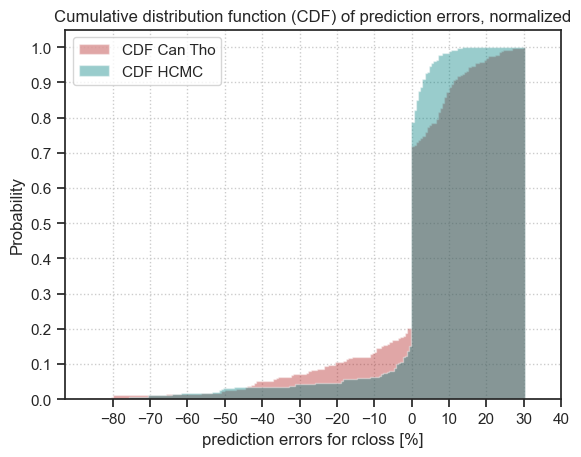

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : True,"grid.linestyle": ":"}
     )#"whitegrid", {"axes.grid" : False})
# style="ticks",


plt.hist(
    #[abs(residuals_hcmc["residual"]), abs(df_cantho_pred_cd["residual"])],   # pred. rel rbred
    [residuals_hcmc["residual"], df_cantho_pred_cd["residual"]],   # pred. rel rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

plt.xticks(np.arange(-80, 50, 10))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xlabel("prediction errors for rbred [%]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction errors, normalized")
plt.legend(loc='best')

# plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


plt.savefig(OUTPATH_BN + "cdf_rbred.png", dpi=300, bbox_inches="tight")



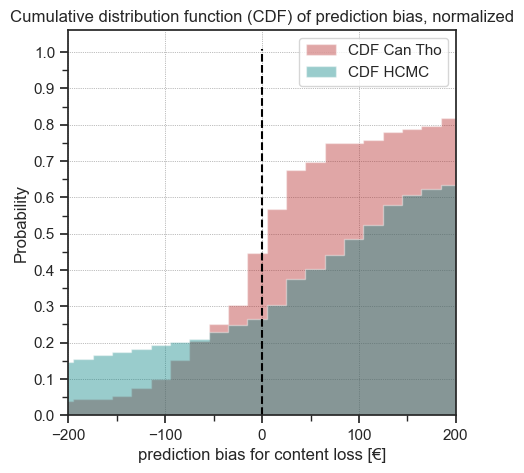

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [df_hcmc_adegree["residual"], df_cantho_adegree["residual"]],  # pred abs closs
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


# # plt.xticks(np.arange(-80, 50, 10))
# plt.xticks(np.arange(-2000, 3000, 500), minor=True)
# # plt.yticks(np.arange(0, 1.0, 0.1))
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-400, 400, facecolor='grey', alpha=0.3)

# ## zoomed in
# plt.xlim(-400, 400)
# plt.xticks(np.arange(-400, 401, 100))
# plt.xticks(np.arange(-400, 401, 50), minor=True)
# # plt.xt(np.arange(-400, 401, 100))
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


## zoomed in
plt.xlim(-200, 200)
plt.xticks(np.arange(-200, 201, 100))
plt.xticks(np.arange(-200, 201, 50), minor=True)
# plt.xt(np.arange(-400, 401, 100))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for content loss [€]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction bias, normalized")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


#plt.savefig(OUTPATH_BN + "cdf_acloss.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPATH_BN + "cdf_zoomed_acloss.png", dpi=300, bbox_inches="tight")



maps each possible value of the random variable to the probability that the variable is less than or equal to that value

see that for cantho more:

Cumulative distribution functions are fantastic for comparing two distributions. By comparing the CDFs of two random variables, we can see if one is more likely to be less than or equal to a specific value than the other.


# Leftovers

### Scatterplot obs ~ pred

In [ ]:
# from matplotlib.colors import to_rgba



# def plot_observed_predicted(y_true, y_pred, hue=None, xlabel="observed", ylabel="predicted", alpha=0.6, legend=False, outfile="test.png"):
#     """
#     Scatter plot of observations vs predictions with optional class colors
#     """
#     # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue

#     sns.set(style="white", font_scale=1.2)
    
#     color_dict = {
#         0: to_rgba('darkgrey', alpha), # set transparency for each class independently
#         1: to_rgba('steelblue', alpha)
#     }
    
#     g = sns.JointGrid(
#         x=y_true, y=y_pred, hue=hue,
#         height=5, space=0,)
#     # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
#     p = sns.scatterplot(
#         x=rbred_true, y=rbred_pred, hue=hue, 
#         palette=color_dict, edgecolors=color_dict, legend=legend, 
#         ax=g.ax_joint)
    
#     if legend == True:
#         #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
#         plt.setp(p.get_legend().get_texts(), fontsize='12')  
#         plt.setp(p.get_legend().get_title(), fontsize='15')

#     g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

#     g1 = sns.regplot(
#         x=rbred_true, y=rbred_pred, 
#         line_kws={"lw":1.},
#         scatter=False, ax=g.ax_joint)
#     regline = g1.get_lines()[0]
#     regline.set_color('steelblue')

#     x0, x1 = (0, 100) 
#     y0, y1 = (0, 100)
#     lims = [min(x0, y0), max(x1, y1)]
#     g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
#     g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)

#     # save plot
#     plt.savefig( outfile, dpi=300, bbox_inches="tight")

#     plt.show()

#     # plt.setp(ax1.get_legend().get_texts(), fontsize='22') # for legend text
#     # plt.suptitle("HCMC: Estimation of relative content loss")
#     # plt.tight_layout()
#     # plt.show()


In [ ]:
## #FLO'S fancy scatterplot with histos 

# import math

# from matplotlib.gridspec import GridSpec
# import mpl_scatter_density # adds projection="scatter_density"
# from matplotlib.colors import LinearSegmentedColormap


# def create_bins(y, bin_size=1):
#     # lower bound inclusive
#     min_age = math.floor(y.min())
#     # upper bound inclusive for histogram plotting, exclusive for categorizing variables
#     max_age = math.ceil(y.max())
#     return list(range(min_age, max_age + 1))[0::bin_size]

# # age_bins(y_pred_org["y_true"])


# def plot_relative_grid(y_true, y_pred, bin_size=5, **kwargs):

#     bins = create_bins(y_pred, bin_size=bin_size)
#     ticks = [0, 20, 40, 60, 80, 100]
#     X, Y = np.meshgrid(bins, bins)
#     H = np.histogram2d(y_true, y_pred, bins=bins)[0]
#     # H_norm: each row describes relative share of all prediction loss bands for businesses of a certain test band
#     H_norm = (H.T / H.sum(axis=1)).T

#     fig = plt.figure(figsize=(8, 8))
#     gs = GridSpec(4, 4)

#     ax_scatter = fig.add_subplot(gs[1:4, 0:3])
#     ax_hist_x = fig.add_subplot(gs[0,0:3])
#     ax_hist_y = fig.add_subplot(gs[1:4, 3])

#     cmap = LinearSegmentedColormap.from_list("", ["white", "steelblue"])
#     colors = ["lightsteelblue", "lightsteelblue", "plum"]

#     ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color="darkgrey")
#     ax_scatter.pcolormesh(Y,X, H_norm, cmap=cmap, rasterized=True)   # modified to have y_pred on y-axis
#     ax_scatter.set_yticks(ticks, labels=ticks)
#     ax_scatter.set_xticks(ticks, labels=ticks)

#     ax_hist_x.hist(y_true, bins=bins, color=colors[0], alpha=0.7)
#     ax_hist_y.hist(y_pred, bins=bins, orientation="horizontal", color=colors[0], alpha=0.7)

#     ax_hist_x.set_axis_off()
#     ax_hist_y.set_axis_off()
#     fig.subplots_adjust(hspace=0.05, wspace=0.02)

#     ax_scatter.spines["top"].set_linewidth(0.5)
#     ax_scatter.spines["right"].set_linewidth(0.5)
#     ax_scatter.spines["left"].set_linewidth(0.5)
#     ax_scatter.spines["bottom"].set_linewidth(0.5)

#     ax_scatter.set_xlabel("Observed")
#     ax_scatter.set_ylabel("Predicted")
#     # fig.colorbar(ax_scatter, label="Number of points per pixel", orientation="horizontal")

#     plt.suptitle("HCMC: Estimation of relative content loss")

# plot_relative_grid(rbred_true, rbred_pred, bin_size=2)

# # TODO rmeove shift to right 
# # TODO implement colorbar horizontal with Number of points per pixel

In [ ]:

# sns.set(style="white", font_scale=1.2)

# fig = plt.figure(figsize=(10,10))
# # ax = fig.add_subplot(1, 1, 1, projection="scatter_density")


# g = sns.JointGrid(
#     x=degree_results["y_true"], y=degree_results["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 
# # cb = fig.colorbar(g, label="counts") # ax=ax 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
# # density = ax.scatter_density(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     cmap=white_viridis
# # )
# # fig.colorbar(density, label="Number of points per pixel")

# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.suptitle(f"HCMC degree of loss, based on {degree_results.shape[0]} samples")

# # hb = ax.hexbin(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     gridsize=10, cmap="viridis")
# # ax.set(xlim=(0, 100) , ylim=(0, 100) )
# # # ax.set_title("Hexagon binning")
# # cb = fig.colorbar(hb, ax=ax, label="counts")


# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()


In [ ]:
# cantho

# sns.set(style="white", font_scale=1.2)


# g = sns.JointGrid(
#     x=y_true, y=y_pred, 
#     # x=pred_d_cantho["y_true"], y=pred_d_cantho["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()

###################################

# g = sns.JointGrid(
#     x=rbred_true, 
#     y=rbred_pred, 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.suptitle("Can Tho: Estimation of relative content loss")
# plt.show()

#### Inference

In [ ]:
# #-----------------------------------------------------------------------------
# # Function 5 - inference - making inference with the BN model
# #-----------------------------------------------------------------------------

# condition=[1] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target_degree (predict)
# values = df_hcmc_d.iloc[:,condition].to_numpy() # data for conditionalization

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_d, # DataFrame with df_hcmc
#              # Output="mean")    # type of output data
#               Output="median")    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

# ## predict target_degree
# y_pred = F.squeeze()

# # Fill out the column(s) which are predicted
# y_true=df_hcmc_d.iloc[:,0].to_numpy()

# # Calculate coefficient of determination
# A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
# B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
# correlation = (np.dot(B, A.T)/B.shape[0])
# R2=correlation**2

# # Calculate evaluation metrics
# MAE = np.mean(np.abs(y_pred-y_true))
# MBE = np.mean(y_pred-y_true)
# RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

# print("MAE,:", MAE)  
# print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  
